# Generate a Mock Dataset

Generate a simulated TF dataset as follows:

* Merge the iron photometric + spectroscopic catalogs with the SGA2020 catalog.
* Apply all photometric corrections used in the TF analysis.
* Cross-match with one of the BGS mocks.
* Apply photometric and morphological cuts used in the PV survey for late-type galaxies.
* Generate mock rotational velocities using an inverted TFR best fit from the data.
* Generate mock TFR distances. 

In [1]:
import os
import shutil
import h5py
import fitsio
import pickle
import healpy as hp
import pandas as pd
import numpy as np
import scipy as sp
import time

from itertools import groupby

from csaps import csaps
from scipy.interpolate import PchipInterpolator, UnivariateSpline
from scipy.stats import binned_statistic
from scipy.odr import ODR, Model, RealData
from scipy.spatial import KDTree
from scipy import integrate, interpolate, special, stats, optimize

#- Global file path for PV analysis.
#  Set to the NERSC folder /global/cfs/cdirs/desi/science/td/pv by default.
#  Set it to something else if working offline.
pvpath = '/global/cfs/cdirs/desi/science/td/pv'
mockpath = os.path.join(pvpath, 'mocks')
tfmockpath = os.path.join(mockpath, 'TF_mocks')

from corner import corner
from hyperfit.linfit import LinFit

#- Path to TF_mocks: code for Blanton's k-corrections.
import sys
sys.path.append(tfmockpath)
import TF_photoCorrect as tfpc

from astropy import units as u
from astropy.io import fits
from astropy.table import Table
from astropy.cosmology import Planck18, FlatLambdaCDM, units
from astropy.coordinates import SkyCoord, Distance

from astropy import constants as const
from tqdm import tqdm
from glob import glob
from hdbscan import HDBSCAN
from astroML.plotting import scatter_contour

import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib import cm

cmap = cm.get_cmap('tab10')

import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

from sklearn.covariance import EllipticEnvelope
from matplotlib.patches import Ellipse
from scipy.stats import chi2

sys.path.insert(1, '/global/u1/s/sgmoore1/DESI_SGA/TF/')
from hyperfit_v2 import MultiLinFit
from line_fits import hyperfit_line_multi
from help_functions import profile_histogram
from DESI_functions import rz_table, FP_func, omega_m


/global/homes/s/sgmoore1/.local/lib/python3.10/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')
/tmp/ipykernel_72848/3733636256.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


In [2]:
mock_num = 540

In [3]:
mpl.rc('font', size=11)

## Iron Data + SGA Catalog

Follow the procedure used in FP mock generation: read in iron data relevant for the TFR for cross-matching to the BGS mocks, producing a simulated set with realistic galaxy observables.

Here we merge the fullsweep and iron specprod catalogs to reproduce cuts when cross-matching with the mocks.

As a final step, get any missing SGA data directly from the SGA 2020 catalog.

In [4]:
#- Read in the iron fullsweep and specprod catalogs.
sw_keys = ['targetid', 'survey', 'program', 'healpix', 'target_ra', 'target_dec',
           'z', 'zerr', 'zwarn', 'inbasiccuts', 'has_corrupt_phot',
           'mag_g', 'mag_r', 'mag_z',
           'morphtype', 'sersic', 'BA_ratio',
           'circ_radius', 'circ_radius_err', 'uncor_radius', 'SGA_id', 'radius_SB25']

ironsweep = os.path.join(pvpath, 'redshift_data/Y1/iron_fullsweep_catalogue_z012.csv')
iron = pd.read_csv(ironsweep, usecols=sw_keys)

#- Read in the spectroscopic production table generated by Caitlin Ross.
sp_keys = ['targetid', 'survey', 'program', 'healpix',
           'mag_err_g', 'mag_err_r', 'mag_err_z', 
           'deltachi2']

ironspec = os.path.join(pvpath, 'redshift_data/Y1/specprod_iron_healpix_z015.csv')
ironsp = pd.read_csv(ironspec, usecols=sp_keys)

#- Cross-match the catalogs.
iron = pd.merge(iron, ironsp, 
                left_on=['targetid', 'survey', 'program', 'healpix'],
                right_on=['targetid', 'survey', 'program', 'healpix'], how='inner')

#- Object selection from the spectro pipeline:
#  1. Valid SGA ID, which implicitly enforces a size selection.
#  2. Delta-chi2 > 25.
#  3. No redrock warnings.
select = (iron['SGA_id'] > 0) & \
         (iron['deltachi2'] >= 25) & \
         (iron['zwarn'] == 0)

iron = iron.drop(iron[~select].index)

#- Read the SGA catalog and match on SGA_ID.
#  This is needed to access R_26 and other quantities at the mag 26 isophote.
sgafile = '/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits'
sgacat = Table.read(sgafile, 'ELLIPSE')
sgacat.rename_column('SGA_ID', 'SGA_id')
sgacat.rename_column('RA', 'SGA_ra')
sgacat.rename_column('DEC', 'SGA_dec')
sgacat = sgacat['SGA_ra', 'SGA_dec', 'SGA_id', 'D26', 'G_MAG_SB26', 'G_MAG_SB26_ERR', 'R_MAG_SB26', 'R_MAG_SB26_ERR', 'Z_MAG_SB26', 'Z_MAG_SB26_ERR'].to_pandas()
sgacat = sgacat.drop(sgacat[sgacat['R_MAG_SB26'] < 0].index)

iron = pd.merge(iron, sgacat, how='inner', on=['SGA_id'])

In [5]:
#- Drop NaN
iron = iron.dropna()
iron

,survey,program,healpix,targetid,target_dec,target_ra,z,zerr,zwarn,morphtype,...,mag_err_r,SGA_ra,SGA_dec,D26,G_MAG_SB26,G_MAG_SB26_ERR,R_MAG_SB26,R_MAG_SB26_ERR,Z_MAG_SB26,Z_MAG_SB26_ERR
0,sv1,bright,34723,39627082556248187,-30.586432,58.890261,0.093327,1.755050e-05,0,SER,...,0.000430,58.890261,-30.586432,0.575315,17.063408,0.034668,16.134380,0.038069,15.478448,0.039409
1,sv1,bright,34725,39627082589804885,-30.509964,61.244826,0.058229,3.289745e-06,0,SER,...,0.000833,61.244826,-30.509964,0.398020,17.159575,0.005541,16.691721,0.005926,16.403215,0.006768
2,sv1,bright,34703,39627082593998226,-30.408004,61.518464,0.059050,2.278493e-06,0,SER,...,0.000355,61.518464,-30.408004,0.998481,16.092411,0.024773,15.328482,0.026500,14.777832,0.026026
3,sv1,bright,34729,39627087765574578,-30.251105,58.278362,0.081022,1.363088e-05,0,SER,...,0.001176,58.278362,-30.251105,0.427528,18.176348,0.028036,17.460354,0.029271,16.949606,0.031180
4,sv1,bright,34729,39627087773962063,-30.188369,58.780902,0.096937,1.941603e-05,0,SER,...,0.000785,58.780902,-30.188369,0.648811,17.540487,0.039971,16.529564,0.041773,15.713690,0.042567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102514,main,dark,7975,2852649649045504,72.895711,131.867353,0.011291,7.328162e-06,0,DEV,...,0.000785,131.867353,72.895711,0.841495,16.188450,0.005690,15.252360,0.006012,14.736343,0.008489
102515,main,dark,7973,2852649653239808,72.926464,133.218536,0.012603,7.566643e-07,0,DEV,...,0.000462,133.218536,72.926464,1.141312,15.233910,0.016896,14.147840,0.015995,13.483636,0.021117
102516,main,dark,8034,2852673590132736,76.634771,140.593982,0.076971,4.815062e-06,0,SER,...,0.001131,140.593982,76.634771,0.515602,16.521830,0.005591,15.891319,0.005790,15.526414,0.006989
102517,sv3,bright,11604,39633456283519525,66.170195,266.658931,0.117068,1.531648e-05,0,SER,...,0.001742,266.658931,66.170195,0.686332,16.746572,0.019684,16.290340,0.016576,16.699310,0.030471


### Keep only Galaxy Centers

The iron catalog may include some off-axis measurements of SGA galaxies that pass the spectroscopic cuts. Remove them with a cone-angle cut, comparing the SGA centers (from Tractor) to the target RA, Dec in DESI. The cut is

$$
\frac{\angle(\mathbf{r}_\mathrm{SGA}, \mathbf{r}_\mathrm{fiber})}{D_{26}/2} < 0.1
$$

See details in Kelly's [SGA selection notebook for iron](https://github.com/DESI-UR/DESI_SGA/blob/master/TF/Y1/iron_rot_vel.ipynb).

Note that requiring a nonzero $m_{r,\mathrm{SB_{26}}}$ may remove all spectra not measured on galaxy centers, making this cut redundant.

In [6]:
coords_sga = SkyCoord(ra=iron['SGA_ra'], dec=iron['SGA_dec'], unit='degree')
coords_iron = SkyCoord(ra=iron['target_ra'], dec=iron['target_dec'], unit='degree')
sep2d = coords_iron.separation(coords_sga)
select = (2*sep2d.to_value('arcmin') / iron['D26']) < 0.1

iron = iron.drop(iron[~select].index)

In [7]:
iron

,survey,program,healpix,targetid,target_dec,target_ra,z,zerr,zwarn,morphtype,...,mag_err_r,SGA_ra,SGA_dec,D26,G_MAG_SB26,G_MAG_SB26_ERR,R_MAG_SB26,R_MAG_SB26_ERR,Z_MAG_SB26,Z_MAG_SB26_ERR
0,sv1,bright,34723,39627082556248187,-30.586432,58.890261,0.093327,1.755050e-05,0,SER,...,0.000430,58.890261,-30.586432,0.575315,17.063408,0.034668,16.134380,0.038069,15.478448,0.039409
1,sv1,bright,34725,39627082589804885,-30.509964,61.244826,0.058229,3.289745e-06,0,SER,...,0.000833,61.244826,-30.509964,0.398020,17.159575,0.005541,16.691721,0.005926,16.403215,0.006768
2,sv1,bright,34703,39627082593998226,-30.408004,61.518464,0.059050,2.278493e-06,0,SER,...,0.000355,61.518464,-30.408004,0.998481,16.092411,0.024773,15.328482,0.026500,14.777832,0.026026
3,sv1,bright,34729,39627087765574578,-30.251105,58.278362,0.081022,1.363088e-05,0,SER,...,0.001176,58.278362,-30.251105,0.427528,18.176348,0.028036,17.460354,0.029271,16.949606,0.031180
4,sv1,bright,34729,39627087773962063,-30.188369,58.780902,0.096937,1.941603e-05,0,SER,...,0.000785,58.780902,-30.188369,0.648811,17.540487,0.039971,16.529564,0.041773,15.713690,0.042567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102514,main,dark,7975,2852649649045504,72.895711,131.867353,0.011291,7.328162e-06,0,DEV,...,0.000785,131.867353,72.895711,0.841495,16.188450,0.005690,15.252360,0.006012,14.736343,0.008489
102515,main,dark,7973,2852649653239808,72.926464,133.218536,0.012603,7.566643e-07,0,DEV,...,0.000462,133.218536,72.926464,1.141312,15.233910,0.016896,14.147840,0.015995,13.483636,0.021117
102516,main,dark,8034,2852673590132736,76.634771,140.593982,0.076971,4.815062e-06,0,SER,...,0.001131,140.593982,76.634771,0.515602,16.521830,0.005591,15.891319,0.005790,15.526414,0.006989
102517,sv3,bright,11604,39633456283519525,66.170195,266.658931,0.117068,1.531648e-05,0,SER,...,0.001742,266.658931,66.170195,0.686332,16.746572,0.019684,16.290340,0.016576,16.699310,0.030471


## Apply Dust and K-corrections

There are four photometric corrections that need to be applied.

1. N vs. S imaging catalog photometric systematics.
2. $k$-corrections to $z=0.1$.
3. Global Milky Way dust corrections using the maps from Zhou+, 2024.
4. Per-galaxy internal dust corrections based on the galaxies' inclination angles.

The corrections, applied to the $r$-band magnitudes, are summed as

$$
A_\mathrm{sys} + A_k + A_\mathrm{MW} + A_\mathrm{dust}
$$

### Imaging Systematics

In [8]:
#- Apply imaging survey systematics: compute photometric system (N or S)
#  Note that we need the RA,Dec of the *data*, not the mocks, because the corrections
#  are applied to the observed magnitudes from SGA (MAG_R_SB26, etc.).
c = SkyCoord(iron['target_ra'], iron['target_dec'], unit='degree')
isnorth = (c.galactic.b > 0) & (iron['target_dec'] > 32.375)
iron['photsys'] = 'S'
iron.loc[isnorth, 'photsys'] = 'N'

#- Adjust northern photometry to DECaLS
Asys, Asys_err = tfpc.BASS_corr(iron['photsys'])

### K Correction

In [9]:
# #- This is based on the kcorrect package by Blanton (https://kcorrect.readthedocs.io/)
# #  Note that we need the RA,Dec of the *data*, not the mocks, because the corrections
# #  are applied to the observed magnitudes from SGA (MAG_R_SB26, etc.).
# select = iron['z'] > 0

# kc = tfpc.k_corr(iron['z'][select], 
#                 [iron['G_MAG_SB26'][select],     iron['R_MAG_SB26'][select],     iron['Z_MAG_SB26'][select]], 
#                 [iron['G_MAG_SB26_ERR'][select], iron['R_MAG_SB26_ERR'][select], iron['Z_MAG_SB26_ERR'][select]], 
#                 z_corr=0.1)

# Ak = np.zeros((len(iron), 3))
# Ak[select] = kc

### MW Dust Correction

In [10]:
#- Compute MW dust corrections
#  Note that we need the RA,Dec of the *data*, not the mocks, because the corrections
#  are applied to the observed magnitudes from SGA (MAG_R_SB26, etc.).
dustmap = '/global/cfs/cdirs/desi/public/papers/mws/desi_dust/y2/v1/maps/desi_dust_gr_512.fits'
ebv = Table.read(dustmap)
Adust, Adust_err = tfpc.MW_dust(iron['target_ra'].values, iron['target_dec'].values, ebv)

#- Mask out NaNs
for i, band in enumerate('grz'):
    isnan_gal = np.isnan(Adust[i])
    if np.any(isnan_gal):
        logging.info(f'Removing NaN for MW dust correction, band {band}')
        Adust[i][isnan_gal] = 0
        Adust_err[i][isnan_gal] = 0

/global/cfs/cdirs/desi/science/td/pv/mocks/TF_mocks/TF_photoCorrect.py:90: UserWarning: Warning: converting a masked element to nan.
  EBV_err[i] = ebv_map['EBV_GR_ERR'][i_ebv]


### Apply MW, K-Correction, and Imaging Systematics Corrections Prior to Internal Dust Correction

In [11]:
#- Apply MW dust, k-corrections, and photometric systematic corrections to the data.
for i, band in enumerate('GRZ'):
    iron[f'{band}_MAG_SB26_tmp'] = iron[f'{band}_MAG_SB26'] - Adust[i] + Asys #+ Ak[:,i]
    iron[f'{band}_MAG_SB26_ERR_tmp'] = np.sqrt(iron[f'{band}_MAG_SB26_ERR']**2 + Adust_err[i]**2 + Asys_err**2)

### Internal Dust Correction 

Correct m_r for the internal galactic dust, assuming that as we look through higher inclinations we're viewing the galaxy through its dust lanes. Details in [this notebook by Kelly](https://github.com/DESI-UR/DESI_SGA/blob/master/TF/Y1/TF_iron_internal-dustCorr.ipynb).

Best fit:     [-1.38464984  0.75677019]
uncertainty:  [0.08825016 0.04843631]


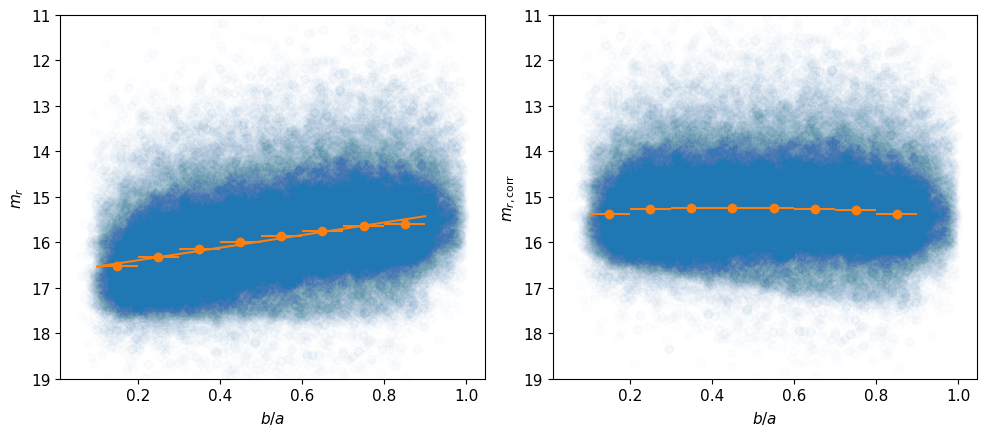

In [12]:
#- Kelly applies an empirical fit to the internal dust in each galaxy. Steps:
#   1. Apply "known" corrections (k-correction, MW dust).
#   2. Fit m_r_corr (corrected) vs spiral b/a
#   3. Zero out this linear dependence.

#- Set up a binned data set and perform the fit
ba_bins = np.arange(0.1,1,0.1)
ba = 0.5*(ba_bins[1:] + ba_bins[:-1])
ba_err = 0.5*np.diff(ba_bins)
m_r_median = np.median(iron['R_MAG_SB26_tmp'])
m_r, _, _ = binned_statistic(iron['BA_ratio'], iron['R_MAG_SB26_tmp'], statistic='median', bins=ba_bins)
n_bin, _, _ = binned_statistic(iron['BA_ratio'], iron['R_MAG_SB26_tmp'], statistic='count', bins=ba_bins)
m_r_err, _, _ = binned_statistic(iron['BA_ratio'], iron['R_MAG_SB26_tmp'], statistic='std', bins=ba_bins)
m_r_err /= np.sqrt(n_bin)

linear_fit = lambda coeff, x: coeff[0]*x + coeff[1]
model = Model(linear_fit)
data = RealData(ba, m_r - m_r_median, sx=ba_err, sy=m_r_err)
odr = ODR(data, model, beta0=[1, 1])

result = odr.run()
coeff = result.beta
coeff_err = result.sd_beta
print('Best fit:    ', coeff)
print('uncertainty: ', coeff_err)

fig, axes = plt.subplots(1,2, figsize=(10,4.5), tight_layout=True, sharex=True)#, sharey=True)
ax = axes[0]
ax.scatter(iron['BA_ratio'], iron['R_MAG_SB26_tmp'], alpha=0.01)
ax.errorbar(ba, m_r, xerr=ba_err, yerr=m_r_err, fmt='o', color='tab:orange')
ax.plot(ba_bins, coeff[0]*ba_bins + coeff[1] + m_r_median, color='tab:orange')
ax.set(ylim=(19, 11),
       ylabel='$m_{r}$',
       xlabel='$b/a$');

#- Compute the internal dust correction
A_int, A_int_err = tfpc.internal_dust(iron['BA_ratio'].values, coeff, coeff_err)

ax = axes[1]
ax.scatter(iron['BA_ratio'], iron['R_MAG_SB26_tmp'] - A_int, alpha=0.01)
m_r, _, _ = binned_statistic(iron['BA_ratio'], iron['R_MAG_SB26_tmp'] - A_int, statistic='median', bins=ba_bins)
ax.errorbar(ba, m_r, xerr=ba_err, yerr=m_r_err, fmt='o', color='tab:orange')
ax.set(ylim=(19, 11),
       ylabel='$m_{r,\mathrm{corr}}$',
       xlabel='$b/a$')

# fig.savefig('tfr_mock_internal_dust_correction.png', dpi=150);

#- Update the r-band magnitudes
iron['R_MAG_SB26_CORR'] = iron['R_MAG_SB26_tmp'] - A_int
iron['R_MAG_SB26_ERR_CORR'] = np.sqrt(iron['R_MAG_SB26_ERR_tmp']**2 + A_int_err**2)

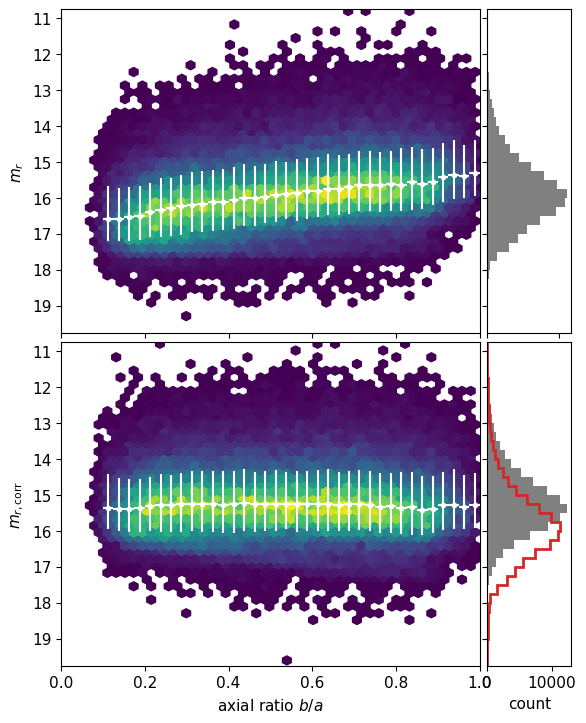

In [13]:
fig, axes = plt.subplots(2,2, figsize=(6,7.5),
                         gridspec_kw={'hspace':0.03, 'wspace':0.0295, 'width_ratios':[5,1]})

# m_r_bins = np.arange(19.75, 10.5, -0.25)
m_r_bins = np.arange(10.75, 20, 0.25)
ba_bins = np.arange(0.1, 1 + 0.025, 0.025)
ba = 0.5*(ba_bins[1:] + ba_bins[:-1])
ba_err = 0.5*np.diff(ba_bins)
m_r_median = np.median(iron['R_MAG_SB26_tmp'])
m_r, _, _ = binned_statistic(iron['BA_ratio'], iron['R_MAG_SB26_tmp'], statistic='median', bins=ba_bins)
n_bin, _, _ = binned_statistic(iron['BA_ratio'], iron['R_MAG_SB26_tmp'], statistic='count', bins=ba_bins)
m_r_err, _, _ = binned_statistic(iron['BA_ratio'], iron['R_MAG_SB26_tmp'], statistic='std', bins=ba_bins)
m_r_err_lo, _, _ = binned_statistic(iron['BA_ratio'], iron['R_MAG_SB26_tmp'], statistic=lambda x: np.percentile(x, [16]), bins=ba_bins)
m_r_err_hi, _, _ = binned_statistic(iron['BA_ratio'], iron['R_MAG_SB26_tmp'], statistic=lambda x: np.percentile(x, [84]), bins=ba_bins)
# m_r_err /= np.sqrt(n_bin)

ax = axes[0,0]
ax.hexbin(iron['BA_ratio'], iron['R_MAG_SB26_tmp'], gridsize=(45,30), cmap='viridis', mincnt=2)
ax.errorbar(ba, m_r, xerr=ba_err, yerr=[m_r - m_r_err_lo, m_r_err_hi - m_r], fmt='.', color='white')

ax.set(xlim=(0,1),
       ylim=(19.75,10.75),
       ylabel=r'$m_r$',
       xticklabels=[])

ax = axes[0,1]
ax.hist(iron['R_MAG_SB26_tmp'], bins=m_r_bins, orientation='horizontal', color='gray')
ax.set(ylim=(19.75,10.75),
       yticklabels=[],
       xticklabels=[])

m_r, _, _ = binned_statistic(iron['BA_ratio'], iron['R_MAG_SB26_tmp']  - A_int, statistic='median', bins=ba_bins)
n_bin, _, _ = binned_statistic(iron['BA_ratio'], iron['R_MAG_SB26_tmp']  - A_int, statistic='count', bins=ba_bins)
m_r_err, _, _ = binned_statistic(iron['BA_ratio'], iron['R_MAG_SB26_tmp']  - A_int, statistic='std', bins=ba_bins)
m_r_err_lo, _, _ = binned_statistic(iron['BA_ratio'], iron['R_MAG_SB26_tmp']  - A_int, statistic=lambda x: np.percentile(x, [16]), bins=ba_bins)
m_r_err_hi, _, _ = binned_statistic(iron['BA_ratio'], iron['R_MAG_SB26_tmp']  - A_int, statistic=lambda x: np.percentile(x, [84]), bins=ba_bins)

ax = axes[1,0]
ax.hexbin(iron['BA_ratio'], iron['R_MAG_SB26_tmp'] - A_int, gridsize=(45,30), cmap='viridis', mincnt=2)
ax.errorbar(ba, m_r, xerr=ba_err, yerr=[m_r - m_r_err_lo, m_r_err_hi - m_r], fmt='.', color='white')

ax.set(xlim=(0,1),
       ylim=(19.75,10.75),
       xlabel=r'axial ratio $b/a$',
       ylabel=r'$m_{r,\mathrm{corr}}$')

ax = axes[1,1]
ax.hist(iron['R_MAG_SB26_tmp'] - A_int, bins=m_r_bins, orientation='horizontal', color='gray')
ax.hist(iron['R_MAG_SB26_tmp'], bins=m_r_bins, orientation='horizontal', histtype='step', lw=2, color='tab:red')
ax.set(ylim=(19.75,10.75),
       yticklabels=[],
       xlabel='count')

fig.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.075)
fig.savefig('TF_mock_syst_corr.png', dpi=200)

## BGS Mock Catalog

Read in one of the mock catalog files and cross-match to iron.

In [14]:
#- There are 25 BGS mocks and (usually) 27 realizations per mock.
#  Pick one, it doesn't matter which.
mockfiles = sorted(glob(os.path.join(pvpath, 'mocks/BGS_base/v0.5/iron/BGS_PV_AbacusSummit_base*.hdf5')))
n_mock = len(mockfiles)
# mockfile = mockfiles[np.random.randint(n_mock)]
mockfile = mockfiles[mock_num]

print(f'Picked mock file {os.path.basename(mockfile)}.')

Picked mock file BGS_PV_AbacusSummit_base_c000_ph020_r000_z0.11.dat.hdf5.


In [15]:
#- Fill the catalog as a dictionary and convert to a Pandas table.
#  Here we follow the I/O from the FP generator (thanks Cullan).
mock = {}
with h5py.File(mockfile, 'r') as f:
    for key in f.keys():
        if key == 'vel':
            #- Pack the galaxy velocities into labeled vx, vy, vz
            mock['vx'] = f['vel'][:,0]
            mock['vy'] = f['vel'][:,1]
            mock['vz'] = f['vel'][:,2]
        else:
            mock[key] = f[key][()]

        # convert strings to unicode
        if key == 'survey' or key == 'program':
            mock[key] = mock[key].astype('U')

    #- Convert to a pandas table
    mock = pd.DataFrame.from_dict(mock)

    #- Merge with iron on 4 keywords
    mock = mock.merge(iron, how='inner', on=['targetid', 'survey', 'program', 'healpix'])

In [16]:
mock.keys()

Index(['Y1_COMP', 'Y3_COMP', 'Y5', 'abs_mag', 'app_mag', 'col', 'col_obs',
       'dec', 'halo_mass', 'healpix', 'is_cen', 'is_res', 'program', 'ra',
       'survey', 'targetid', 'vx', 'vy', 'vz', 'zcos', 'zobs', 'target_dec',
       'target_ra', 'z', 'zerr', 'zwarn', 'morphtype', 'sersic', 'mag_g',
       'mag_r', 'mag_z', 'uncor_radius', 'BA_ratio', 'circ_radius',
       'circ_radius_err', 'SGA_id', 'radius_SB25', 'inbasiccuts',
       'has_corrupt_phot', 'deltachi2', 'mag_err_g', 'mag_err_z', 'mag_err_r',
       'SGA_ra', 'SGA_dec', 'D26', 'G_MAG_SB26', 'G_MAG_SB26_ERR',
       'R_MAG_SB26', 'R_MAG_SB26_ERR', 'Z_MAG_SB26', 'Z_MAG_SB26_ERR',
       'photsys', 'G_MAG_SB26_tmp', 'G_MAG_SB26_ERR_tmp', 'R_MAG_SB26_tmp',
       'R_MAG_SB26_ERR_tmp', 'Z_MAG_SB26_tmp', 'Z_MAG_SB26_ERR_tmp',
       'R_MAG_SB26_CORR', 'R_MAG_SB26_ERR_CORR'],
      dtype='object')

In [17]:
mock

,Y1_COMP,Y3_COMP,Y5,abs_mag,app_mag,col,col_obs,dec,halo_mass,healpix,...,Z_MAG_SB26_ERR,photsys,G_MAG_SB26_tmp,G_MAG_SB26_ERR_tmp,R_MAG_SB26_tmp,R_MAG_SB26_ERR_tmp,Z_MAG_SB26_tmp,Z_MAG_SB26_ERR_tmp,R_MAG_SB26_CORR,R_MAG_SB26_ERR_CORR
0,0.000000,1.000000,True,-21.468495,16.195766,0.810999,0.830938,4.308205,4.361581e+12,9068,...,0.045233,S,17.151709,0.033744,16.406942,0.037029,15.821846,0.045933,15.675118,0.059554
1,0.000000,0.911565,True,-20.954132,16.711403,1.028747,1.055519,4.538580,4.817142e+12,32364,...,0.038694,S,17.479701,0.038137,16.434531,0.037372,15.551167,0.039416,15.327302,0.079854
2,0.975000,0.975000,True,-20.709988,16.942036,0.449278,0.461332,1.835895,3.302822e+12,31481,...,0.016018,S,17.514775,0.024880,17.063437,0.019914,16.704743,0.017719,16.559322,0.037800
3,0.000000,1.000000,True,-20.424810,17.240273,0.730526,0.747687,7.383247,1.077741e+12,25840,...,0.030840,S,17.799080,0.035434,17.052192,0.034766,16.444612,0.031546,16.019536,0.074434
4,0.719512,0.719512,True,-20.197525,17.457456,0.713218,0.729105,-5.097986,1.033450e+12,9505,...,0.028971,N,18.253989,0.035976,17.502733,0.036349,16.924341,0.036076,16.621238,0.066915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488459,1.000000,1.000000,True,-20.950366,16.697884,0.981579,1.005821,1.321448,3.838528e+12,19981,...,0.033067,S,17.922419,0.051557,17.005503,0.041230,16.301703,0.037784,15.960902,0.078310
488460,0.000000,1.000000,True,-20.253107,17.414045,0.973295,0.999653,-0.897949,8.794870e+11,9267,...,0.046137,S,17.967417,0.047293,17.013033,0.048767,16.227679,0.046884,15.852133,0.088615
488461,0.954839,0.993548,True,-20.262981,17.399657,0.874255,0.896716,-3.024827,1.039777e+12,5450,...,0.032612,N,18.251696,0.045811,17.394357,0.039158,16.777858,0.040485,16.259402,0.082255
488462,0.032258,1.000000,True,-21.283739,16.378242,0.894431,0.917646,1.291884,8.845488e+12,18113,...,0.010725,S,17.371606,0.057722,16.472816,0.039981,15.861379,0.024082,16.146614,0.045063


### Apply TF Selection Cuts

Here apply the late-type galaxy cuts defined in *Target Selection for the DESI Peculiar Velocity Survey*, C. Saulder+, MNRAS 525:1106, 2023. Note that several cuts are the complement of the early-type cuts for the FP sample.

In [18]:
mock_selection = {
    'basic cuts' : 0,
    # '0.03 < z < 0.105' : 0,
    'b/a < cos(25°)' : 0,
    'morphtype' : 0,
    'NaN' : 0
}

#- Apply target selection
print(f'Size of cross-matched iron+mock catalog ..{len(mock):.>20d}')

#- Drop data that doesn't pass the photometric cuts
select = (mock['inbasiccuts'] == 0) | (mock['has_corrupt_phot'] == 1)
mock = mock.drop(mock[select].index)
mock_selection['basic cuts'] = len(mock)
print(f'Size after photometric cuts .........{len(mock):.>20d}')

#- Redshift range cut: remove?
# select = (mock['zobs'] > 0.03) & (mock['zobs'] <= 0.105)
# mock = mock[select]
# mock_selection['0.03 < z < 0.105'] = len(mock)
# print(f'Redshift selection: 0.03 < z < 0.105 {len(mock):.>20d}')

#- B/A ratio cut:
select = mock['BA_ratio'] < np.cos(np.radians(25))
mock = mock[select]
mock_selection['b/a < cos(25°)'] = len(mock)
print(f'Ratio b/a < cos(25 deg) .............{len(mock):.>20d}')

#- Morphology cuts:
select = (mock['morphtype'] == 'EXP') | ((mock['morphtype'] == 'SER') & (mock['sersic'] <= 2))
mock = mock[select]
mock_selection['morphtype'] = len(mock)
print(f'Morphology cuts: ....................{len(mock):.>20d}')

#- Drop any rows with NaN
mock = mock.dropna()
mock_selection['NaN'] = len(mock)
print(f'Drop NaN ............................{len(mock):.>20d}')

Size of cross-matched iron+mock catalog ................488464
Size after photometric cuts .......................488264
Ratio b/a < cos(25 deg) ...........................471642
Morphology cuts: ..................................252990
Drop NaN ..........................................216428


/tmp/ipykernel_72848/3164248107.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(names, rotation=45, ha='right')


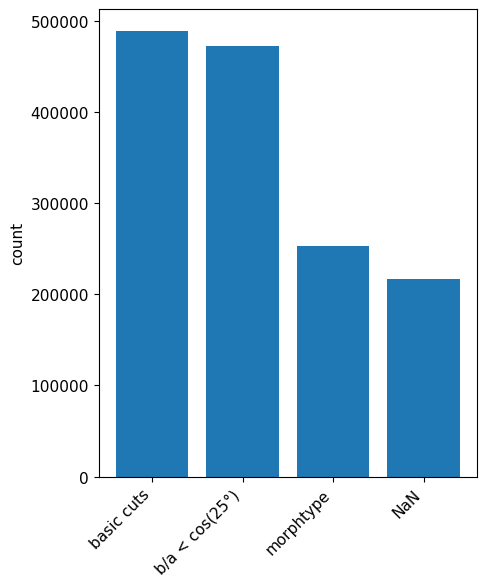

In [19]:
names = list(mock_selection.keys())
values = list(mock_selection.values())

fig, ax = plt.subplots(1, 1, figsize=(5,6), tight_layout=True)
bars = ax.bar(names, values)
ax.set_xticklabels(names, rotation=45, ha='right')
# ax.bar_label(bars, fmt='%d')
ax.set(ylabel='count');#, yscale='log', ylim=[1e3,1.2e4])
fig.set_facecolor('none')
# fig.savefig('tfr_mock_cuts.png', dpi=150)

## Compute TFR Quantities

Assign a rotational velocity using the data. Then use this to infer $M_r$ using the calibrated TFR.

### Set up the Cosmology

Use a flat-$\Lambda$CDM fiducial cosmology with $H_0\equiv100$ km/s/Mpc and $\Omega_m=0.3151$.

In [20]:
h = 1
cosmology = FlatLambdaCDM(H0=100*h, Om0=0.3151)

#### Calculate distances to galaxies based on this cosmology
This will be useful in determining the selection effects

In [21]:
dist = Distance(z=np.abs(mock['zobs']), cosmology=cosmology)
mock['D26_kpc'] = 2*dist.to('kpc')*np.tan(0.5*mock['D26']*u.arcmin)

### Current Y1 TFR Best Fit

TF Y1 best-fit parameters and covariances, corresponding to v9 of the TF Y1 catalog. This comes from the TFR calibration using 7 galaxy clusters (2025-03-28) using Vmax weights to account for the galaxy size function. The TFR fit is

$$
M_r = a \log_{10}{\left(\frac{V_\mathrm{rot}}{V_0}\right)} + b_{0\mathrm{pt}}
$$

with intrinsic scatter $\sigma$ along the magnitude axis. See this [notebook](https://github.com/DESI-UR/DESI_SGA/blob/master/TF/Y1/TF_Y1_cluster_calibration_AnthonyUpdates_weightsVmax-1_KAD.ipynb) in the [DESI_SGA/TF/Y1](https://github.com/DESI-UR/DESI_SGA/tree/master/TF/Y1) GitHub repo.

The parameter vector includes the TFR slope $a$, global zero point $b_{0\text{pt}}$, calibration cluster intercepts $\{b_i\}$, and intrinsic scatter $\sigma$.

In [22]:
# with open('/pscratch/sd/s/sgmoore1/TF/pickles/cov_ab_iron_jointTFR_systematics_test_v10.pickle', 'rb') as tfr_file:
#     cov_ab, tfr_samples, logV0, zmin, zmax, dz, zbins = pickle.load(tfr_file)

# tf_par = np.median(tfr_samples, axis=1)
# a, b, sigma = tf_par[0], tf_par[1:-1], tf_par[-1]

### Current TFR Catalog

Read in the TFR catalog to sample uncertainties in $V_\mathrm{rot}$.

In [23]:
tfr_version = 'v10'

# tfrcatfile = os.path.join(pvpath, f'tfgalaxies/Y1/DESI-DR1_TF_pv_cat_{tfr_version}.fits')
tfrcatfile = os.path.join(pvpath, f'tfgalaxies/Y1/systematic_tests/DESI-DR1_TF_pv_test_cat_{tfr_version}.fits')
tfrcat = Table.read(tfrcatfile)
tfr_params = fits.open(tfrcatfile)
#- Set minimum velocity uncertainty to 7 km/s.
# lowverr = tfrcat['V_0p4R26_ERR'] < 7.
# tfrcat['V_0p4R26_ERR'][lowverr] = 7.

tfrcat['logv_rot'] = np.log10(tfrcat['V_0p4R26'])
tfrcat['logv_rot_err'] = 0.434*tfrcat['V_0p4R26_ERR'] / tfrcat['V_0p4R26']

tfrcat = tfrcat['Z_DESI', 'D26', 'R_MAG_SB26_CORR', 'R_MAG_SB26_ERR_CORR', 'R_ABSMAG_SB26', 'LOGDIST', 'LOGDIST_ERR', 'MU_ZCMB', 'MU_ZCMB_ERR', 'V_0p4R26', 'V_0p4R26_ERR', 'logv_rot', 'logv_rot_err', 'MAIN'].to_pandas()
tfrcat['R_ABSMAG_SB26_ERR'] = tfrcat['R_MAG_SB26_ERR_CORR']
tfrcat

,Z_DESI,D26,R_MAG_SB26_CORR,R_MAG_SB26_ERR_CORR,R_ABSMAG_SB26,LOGDIST,LOGDIST_ERR,MU_ZCMB,MU_ZCMB_ERR,V_0p4R26,V_0p4R26_ERR,logv_rot,logv_rot_err,MAIN,R_ABSMAG_SB26_ERR
0,0.080990,0.417579,16.908298,0.111225,-20.162358,0.045680,0.615490,37.070655,0.000722,122.322388,10.869519,2.087506,0.038565,True,0.111225
1,0.044002,0.495681,17.082012,0.089138,-18.644439,-0.000706,0.804028,35.726451,0.001308,81.348133,6.577976,1.910348,0.035094,True,0.089138
2,0.090040,0.567250,16.069547,0.114575,-21.256016,0.035391,0.331079,37.325563,0.000941,180.655725,13.281536,2.256852,0.031907,True,0.114575
3,0.034026,0.575771,16.818270,0.100157,-18.332957,0.003148,0.843942,35.151228,0.001632,70.102003,12.043673,1.845730,0.074562,True,0.100157
4,0.043319,0.953031,15.419652,0.145746,-20.255496,0.016611,0.550042,35.675148,0.001418,133.778523,10.944416,2.126386,0.035506,True,0.145746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10195,0.116921,0.369286,16.745716,0.079867,-21.159347,0.394910,0.448870,37.905063,0.000560,95.032991,12.384687,1.977874,0.056559,False,0.079867
10196,0.054449,0.376227,17.294092,0.045367,-18.867214,0.016747,0.858717,36.161306,0.001130,44.540700,19.033877,1.648757,0.185464,True,0.045367
10197,0.118856,0.362001,17.734643,0.072459,-20.211017,0.052186,0.537801,37.945660,0.001144,123.942591,22.458671,2.093221,0.078642,True,0.072459
10198,0.133822,0.454465,17.419780,0.141829,-20.803173,-0.028476,0.244961,38.222953,0.000711,172.888233,18.437635,2.237765,0.046284,True,0.141829


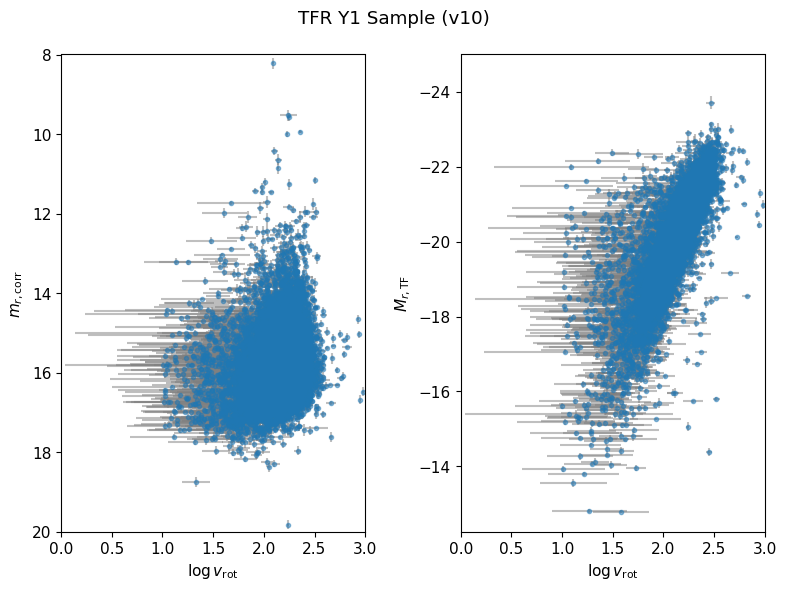

In [24]:
fig, axes = plt.subplots(1,2, figsize=(8,6), tight_layout=True, sharex=True)

ax = axes[0]
ax.errorbar(tfrcat['logv_rot'], tfrcat['R_MAG_SB26_CORR'],
             xerr=tfrcat['logv_rot_err'],
             yerr=tfrcat['R_MAG_SB26_ERR_CORR'],
             fmt='.', 
             alpha=0.5, 
             ecolor='gray')

ax.set(xlim=(0,3),
       xlabel=r'$\log{v_\mathrm{rot}}$',
       ylabel=r'$m_{r,\mathrm{corr}}$',
       ylim=(20,8))

ax = axes[1]
ax.errorbar(tfrcat['logv_rot'], tfrcat['R_ABSMAG_SB26'],
             xerr=tfrcat['logv_rot_err'],
             yerr=tfrcat['R_ABSMAG_SB26_ERR'],
             fmt='.', 
             alpha=0.5, 
             ecolor='gray')

ax.set(xlim=(0,3),
       xlabel=r'$\log{v_\mathrm{rot}}$',
       ylabel=r'$M_{r,\mathrm{TF}}$',
       ylim=(-12.25, -25))

fig.suptitle(f'TFR Y1 Sample ({tfr_version})')
fig.set_facecolor('none');
# fig.savefig('tfr_y1_sample.png', dpi=180);

### Generate Absolute Magnitudes for TFR Fitting

Procedure:
1. Calculate $M_{r,\mathrm{cos}}$ using $z_\mathrm{cos}$ from the mocks. This explicitly excludes mock peculiar velocities.
1. Compute distance moduli $\mu$ for each *observed* redshift in the mocks, $z_\mathrm{obs}$.
1. Compute $M_{r,\mathrm{obs}}$ using $m_{r,\mathrm{SB26}}$ from cross-matched from data and the generated $\mu$.
1. Scatter $\log{V_\mathrm{rot}}$ by binning the Y1 data in magnitude ($M_{r,\mathrm{cos}}$), computing the $\log{v_\mathrm{rot}}$ CDF in each bin, and randomly sampling new values.

In [25]:
#- Use distmod with cosmological redshifts to compute a "true" absolute magnitude M_r(SB26).
#  Then compute a central value for rotational velocity using this "true" magnitude.
Mr_cos = mock['R_MAG_SB26_CORR'] - cosmology.distmod(mock['zcos']).to_value('mag')

#- Compute an observed magnitude based on the PVs in the mock catalog.
mu_obs_mock = cosmology.distmod(mock['zobs']).to_value('mag')
mock['MU_OBS_MOCK'] = mu_obs_mock
Mr_obs_mock = (mock['R_MAG_SB26_CORR'] - mu_obs_mock).to_numpy()
Mr_obs_err_mock = mock['R_MAG_SB26_ERR_CORR'].to_numpy()

#- Bin R_ABSMAG_SB26. Merge any bins with < 50 datapoints, working from the ends of the magnitude range.
bins = np.arange(-26, -12 + 0.05, 0.05)
M_r_bins = [bins[0]]
for k in np.arange(1, len(bins)):
    select = (tfrcat['R_ABSMAG_SB26'] > M_r_bins[-1]) & (tfrcat['R_ABSMAG_SB26'] <= bins[k])    
    if np.sum(select) >= 50:
        M_r_bins.append(bins[k])
M_r_bins.append(bins[-1])
N_bins = len(M_r_bins)

print(np.histogram(tfrcat['R_ABSMAG_SB26'], M_r_bins))

#- Loop through the magnitude bins and regenerate log(v_rot) by resampling the data.
#  Try to reduce resampling effects by using a smoothed version of the CDF of log(v_rot).
logvrot_mock = np.zeros_like(Mr_obs_mock)

use_weighted_fit = True

for k in tqdm(np.arange(0, N_bins-1)):
    # # TEST
    # if k > 5*N_bins//9:
    #     break
    
    M_r_min, M_r_max = M_r_bins[k], M_r_bins[k+1]

    #- Select TFR velocity data in this magnitude bin and compute the CDF of log(v_rot).
    i = (tfrcat['R_ABSMAG_SB26'] > M_r_min) & (tfrcat['R_ABSMAG_SB26'] <= M_r_max)
    logvrot_slice = tfrcat['logv_rot'][i].to_numpy()
    logvrot_err_slice = tfrcat['logv_rot_err'][i].to_numpy()

    if use_weighted_fit:
        #- Attempt to build a weighted CDF
        logvrot_bins = np.arange(1, 3.01, 0.01)
        logvrot_pdf_wt, logv_bins = np.histogram(logvrot_slice, bins=logvrot_bins, 
                                                 weights=np.ones_like(logvrot_err_slice)
                                                 # weights=1/logvrot_err_slice**2
                                                )
        logvrot_cdf = np.cumsum(logvrot_pdf_wt) / np.sum(logvrot_pdf_wt)
        
        logvrot_slice = 0.5*(logvrot_bins[1:] + logvrot_bins[:-1])

        #- Keep only the unique elements in the list
        idx = np.cumsum([len(list(g)) for k, g in groupby(logvrot_cdf)])[:-1]
        logvrot_cdf = logvrot_cdf[idx]
        logvrot_slice = logvrot_slice[idx]
        # print(logvrot_cdf.shape, logvrot_slice.shape)
    else:
        #- Default to the unweighted CDF
        logvrot_cdf = np.cumsum(logvrot_slice) / np.sum(logvrot_slice)

    #- Select mock data in this magnitude bin.
    j = (Mr_cos > M_r_min) & (Mr_cos <= M_r_max)
    # j = (Mr_obs_mock > M_r_min) & (Mr_obs_mock <= M_r_max)
    N_mock_slice = np.sum(j)
    un = np.random.uniform(size=N_mock_slice)
    logvrot_mock_slice = csaps(logvrot_cdf, np.sort(logvrot_slice), un).values
    logvrot_mock[j] = logvrot_mock_slice

    #- Apply a velocity cut of 10 to 1000 km/s.
    #  Regenerate any velocities that fall outside the valid range.
    #  Note that an intermediate variable is needed to manage the array slicing.
    bad_vrot = (logvrot_mock[j] < 1) | (logvrot_mock[j] > 3)
    while np.any(bad_vrot):
        N_regen = np.sum(bad_vrot)
        uni = np.random.uniform(size=N_regen)
        logvrot_mock_regen = logvrot_mock[j]
        logvrot_mock_regen[bad_vrot] = csaps(logvrot_cdf, np.sort(logvrot_slice), uni).values
        logvrot_mock[j] = logvrot_mock_regen
        bad_vrot = (logvrot_mock[j] < 1) | (logvrot_mock[j] > 3)

# - Finally, match mock values against the Y1 data to assign uncertainties on logvrot_mock and Mr_obs_mock.
#  Many ways to do this... here just copy the FP approach of grabbing the nearest neighbor in (log v, M_r)
#  from data and taking its uncertainty.
search_tree = KDTree(np.c_[tfrcat['logv_rot'], tfrcat['R_ABSMAG_SB26']])
search_tree.query([1.5, -20])
_, idx = search_tree.query([[x, y] for (x,y) in zip(logvrot_mock, Mr_obs_mock)])

logvrot_err_mock = tfrcat['logv_rot_err'][idx].to_numpy()
Mr_obs_err_mock = mock['R_MAG_SB26_ERR_CORR'].to_numpy()

mock['LOGVROT_MOCK'] = logvrot_mock
mock['LOGVROT_ERR_MOCK'] = logvrot_err_mock
mock['R_ABSMAG_SB26_MOCK'] = Mr_obs_mock
mock['R_ABSMAG_SB26_ERR_MOCK'] = Mr_obs_err_mock

(array([ 71,  52,  63,  66,  78,  71,  62,  65,  69,  88, 101, 117, 104,
       126, 144, 150, 155, 150, 153, 151, 144, 177, 177, 191, 169, 207,
       192, 172, 182, 202, 169, 182, 156, 161, 178, 192, 176, 161, 163,
       168, 155, 165, 147, 146, 151, 152, 140, 147, 124, 128, 128, 116,
       120, 110, 117, 111, 114,  83, 104,  84,  99,  93, 100,  80,  82,
        77,  61,  73,  55,  68, 110,  52,  53, 108,  97,  88,  86,  66,
        70,  62,  61,  60,  65,  51,  62,  50,  51,  50,  51,  22]), array([-26.  , -22.4 , -22.25, -22.15, -22.05, -21.95, -21.9 , -21.85,
       -21.8 , -21.75, -21.7 , -21.65, -21.6 , -21.55, -21.5 , -21.45,
       -21.4 , -21.35, -21.3 , -21.25, -21.2 , -21.15, -21.1 , -21.05,
       -21.  , -20.95, -20.9 , -20.85, -20.8 , -20.75, -20.7 , -20.65,
       -20.6 , -20.55, -20.5 , -20.45, -20.4 , -20.35, -20.3 , -20.25,
       -20.2 , -20.15, -20.1 , -20.05, -20.  , -19.95, -19.9 , -19.85,
       -19.8 , -19.75, -19.7 , -19.65, -19.6 , -19.55, -19.5 , -19.45,
 

100%|██████████| 90/90 [00:00<00:00, 210.30it/s]


#### Apply Alex's Velocity and Dwarf Cuts

Alex's cuts, defined August 2025, are:
* $m_r < \min{(17.75, \mu_\mathrm{CMB} - 17 + 5\log{h})}$, a cut on dwarfs
* $70~\mathrm{km/s} < V_\mathrm{rot}(0.4R_{26}) < 300~\mathrm{km/s}$, a vertical velocity cut
* $V_\mathrm{rot}(0.4R_{26}) < \min{(300~\mathrm{km/s}, 10^{0.3(\mu_\mathrm{CMB} - 34 + 5\log{h}) + 2})}$, a distance-dependent velocity cut

In [26]:
def downsample(mock, size=100):
    """Randomly downsample a mock catalog, without replacement, to some size.

    Parameters
    ----------
    mock: pandas.DataFrame
        Pandas table with a mock catalog.
    size: int
        Size of the final downsampled catalog.

    Returns
    -------
    newmock: pandas.DataFrame
        Downsampled Pandas table.
    """
    Nmock = len(mock)
    idx_downsample = np.random.choice(Nmock, size, replace=False)
    return mock.iloc[idx_downsample]

def TF_FN_func(params, logv, m, err_logv, err_m,
               logvmin=None, logvmax=None,
               Mmin=None):
    """
    Fully vectorized selection function for Tully-Fisher.

    params = [a, b, logV0, sigma_perp]
    Mmin: (nd, N_galaxies)
    """

    a, b, logV0, sigma_perp = params

    # Shapes
    nd, Ngal = Mmin.shape

    dv = logvmax - logvmin

    # -------------------------------------------------
    # Perpendicular variance (shape: Ngal)
    # -------------------------------------------------
    perp_sigma2 = (
        (err_m**2 + a**2 * err_logv**2) / (1.0 + a**2)
        + sigma_perp**2
    )
    perp_sigma = np.sqrt(perp_sigma2)              # (Ngal,)

    # -------------------------------------------------
    # Define A and B
    # -------------------------------------------------
    # A has shape (nd, Ngal)
    A = (Mmin - b + a * logV0) / perp_sigma[None, :]

    # B has shape (Ngal,)
    B = a / perp_sigma

    # -------------------------------------------------
    # Evaluate u at velocity limits
    # -------------------------------------------------
    # Shapes: (nd, Ngal)
    u_min = A - B[None, :] * logvmin
    u_max = A - B[None, :] * logvmax

    # -------------------------------------------------
    # Analytic integral pieces
    # -------------------------------------------------
    term_min = u_min * stats.norm.cdf(u_min) + stats.norm.pdf(u_min)
    term_max = u_max * stats.norm.cdf(u_max) + stats.norm.pdf(u_max)

    # Velocity integral (nd, Ngal)
    integral_v = (term_min - term_max) / B[None, :]

    # Normalize by velocity width
    integral_v /= dv

    # -------------------------------------------------
    # Average over distance bins
    # -------------------------------------------------
    FN = np.mean(integral_v, axis=0)   # (Ngal,)

    FN = np.maximum(FN, 1e-15)

    return np.log10(FN)


def TF_perp_func(params, logdists, zobs, logv, m, err_logv, err_m, Sn, logvmin, sumgals=True, chi_squared_only=False):

    # unpack parameters
    a, b, logv0, sigma_int = params

    # model
    delta = m - (a * (logv - logv0) + b)

    # perpendicular residual
    denom = np.sqrt(1.0 + a**2)
    delta_perp = delta / denom

    # projected measurement variance
    sigma_perp2 = (err_m**2 + a**2 * err_logv**2) / (1.0 + a**2)

    # total variance
    sigma_tot2 = sigma_perp2 + sigma_int**2

    # chi-squared
    chi2 = delta_perp**2 / sigma_tot2
    log_det = np.log(sigma_tot2)

    chi2 *= Sn
    log_det *= Sn

    if chi_squared_only:
        return chi2
    elif sumgals:
        return 0.5 * np.sum(chi2 + log_det)
    else:
        return 0.5 * (chi2 + log_det)

def TF_FP_func(params, logdists, zobs, logv, m,
               err_logv, err_m, Sn,
               logvmin=None,
               sumgals=True,
               chi_squared_only=False):
    """
    Perpendicular Tully-Fisher likelihood.

    params = [a, b, logV0, sigma_int]
        a, b        : slope and intercept
        logV0       : pivot velocity
        sigma_int   : intrinsic perpendicular scatter

    logdists : scalar (0.0 for fitting) or array (for PDF extraction)
    Sn       : selection weights
    """

    a, b, logV0, sigma_int = params

    # Precompute slope geometry
    denom = np.sqrt(1.0 + a**2)

    # -------------------------------------------------
    # CASE 1: Scalar logdists (normal fit)
    # -------------------------------------------------
    if np.isscalar(logdists):

        # Model magnitude
        m_model = a * (logv - logV0) + b

        # Perpendicular residual
        delta = m - m_model
        delta_perp = delta / denom

        # Project measurement errors perpendicular
        sigma_meas2 = (err_m**2 + a**2 * err_logv**2) / (1.0 + a**2)

        # Total variance
        sigma_tot2 = sigma_meas2 + sigma_int**2

        chi2 = delta_perp**2 / sigma_tot2
        log_det = np.log(sigma_tot2)

        # Apply selection weighting
        # chi2 *= Sn
        log_det *= Sn

        if chi_squared_only:
            return chi2

        if sumgals:
            return 0.5 * np.sum(chi2*Sn + log_det)
        else:
            return 0.5 * (chi2*Sn + log_det)

    # -------------------------------------------------
    # CASE 2: Distance grid mode (PDF extraction)
    # -------------------------------------------------
    else:

        logdists = np.asarray(logdists)

        # Shift magnitudes by distance
        m_shifted = m[None, :] + 5.0 * logdists[:, None]

        # Model magnitude
        m_model = a * (logv - logV0) + b
        delta = m_shifted - m_model[None, :]

        delta_perp = delta / denom

        sigma_meas2 = (err_m**2 + a**2 * err_logv**2) / (1.0 + a**2)
        sigma_tot2 = sigma_meas2 + sigma_int**2

        chi2 = delta_perp**2 / sigma_tot2[None, :]
        log_det = np.log(sigma_tot2)[None, :]

        # Apply selection weighting along the galaxy axis
        chi2 *= Sn[None, :]
        log_det *= Sn[None, :]

        return 0.5 * (chi2 + log_det)


#### Plot $M_{R,\mathrm{SB26}}$ for Mocks and TFR Data

Make a side-by-side comparison of the (downsampled) mock catalog and Y1 data.

Apply the quality cuts equally to both.

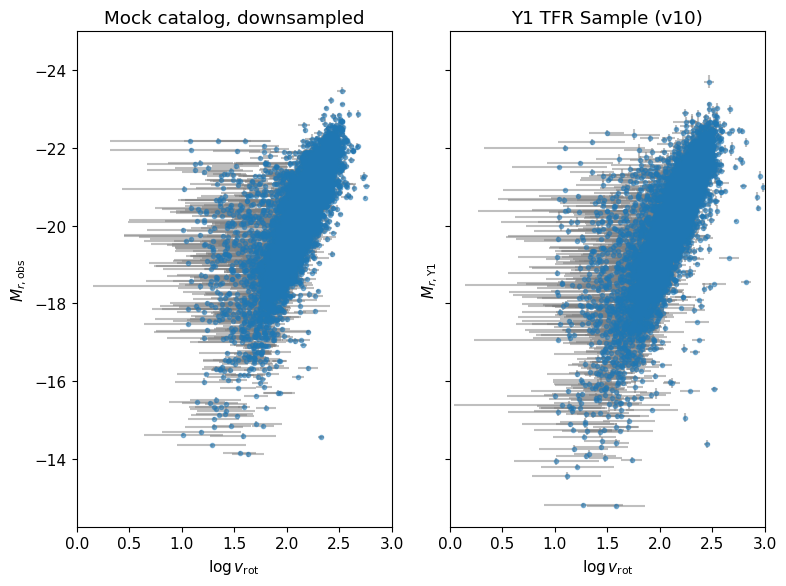

In [27]:
#- Plot Mr vs log(v_rot) for the various steps in the calculation.

fig, axes = plt.subplots(1,2, figsize=(8,6), tight_layout=True, sharex=True, sharey=True)

Ntfr = len(tfrcat)
mock_downsample = downsample(mock, Ntfr)

ax = axes[0]
ax.errorbar(mock_downsample['LOGVROT_MOCK'], mock_downsample['R_ABSMAG_SB26_MOCK'],
            xerr=mock_downsample['LOGVROT_ERR_MOCK'],
            yerr=mock_downsample['R_ABSMAG_SB26_ERR_MOCK'],
            fmt='.', 
            alpha=0.5, 
            ecolor='gray')

# idx_mock_goodv = alex_cuts_velocity(mock_downsample, logv_name='LOGVROT_MOCK', distmod_name='MU_OBS_MOCK')
# idx_mock_notdwarf = alex_cuts_dwarf(mock_downsample, rmag_name='R_MAG_SB26_CORR', distmod_name='MU_OBS_MOCK')
# idx_mock_good = idx_mock_goodv & idx_mock_notdwarf

# idx_tfr_good, idx_mock_good = ellipse_fit(tfrcat['logv_rot'], tfrcat['R_ABSMAG_SB26'], mock_downsample['LOGVROT_MOCK'], mock_downsample['R_ABSMAG_SB26_MOCK'])
# idx_mock_good = ellipse_boolean(mock_downsample['LOGVROT_MOCK'], mock_downsample['R_ABSMAG_SB26_MOCK'], ellipse_mean, ellipse_cov, n_std=ellipse_sigma)

# ax.errorbar(mock_downsample['LOGVROT_MOCK'][idx_mock_good], mock_downsample['R_ABSMAG_SB26_MOCK'][idx_mock_good],
#              xerr=mock_downsample['LOGVROT_ERR_MOCK'][idx_mock_good],
#              yerr=mock_downsample['R_ABSMAG_SB26_ERR_MOCK'][idx_mock_good],
#              fmt='.', 
#              alpha=0.5, 
#              ecolor='gray')

ax.set(xlim=(0,3),
       xlabel=r'$\log{v_\mathrm{rot}}$',
       ylabel=r'$M_{r,\mathrm{obs}}$',
       ylim=(-12.25, -25),
       title=r'Mock catalog, downsampled')

ax = axes[1]
ax.errorbar(tfrcat['logv_rot'], tfrcat['R_ABSMAG_SB26'],
             xerr=tfrcat['logv_rot_err'],
             yerr=tfrcat['R_ABSMAG_SB26_ERR'],
             fmt='.', 
             alpha=0.5, 
             ecolor='gray')

# idx_tfr_goodv = alex_cuts_velocity(tfrcat, logv_name='logv_rot', distmod_name='MU_ZCMB')
# idx_tfr_notdwarf = alex_cuts_dwarf(tfrcat, rmag_name='R_MAG_SB26_CORR', distmod_name='MU_ZCMB')
# idx_tfr_good = idx_tfr_goodv & idx_tfr_notdwarf
# idx_tfr_good = ellipse_boolean(tfrcat['logv_rot'], tfrcat['R_ABSMAG_SB26'], ellipse_mean, ellipse_cov, n_std=ellipse_sigma)

# ax.errorbar(tfrcat['logv_rot'][idx_tfr_good], tfrcat['R_ABSMAG_SB26'][idx_tfr_good],
#              xerr=tfrcat['logv_rot_err'][idx_tfr_good],
#              yerr=tfrcat['R_ABSMAG_SB26_ERR'][idx_tfr_good],
#              fmt='.', 
#              alpha=0.5, 
#              ecolor='gray')

ax.set(xlim=(0,3),
       xlabel=r'$\log{v_\mathrm{rot}}$',
       ylabel=r'$M_{r,\mathrm{Y1}}$',
       ylim=(-12.25, -25),
       title=f'Y1 TFR Sample ({tfr_version})');

fig.set_facecolor('none');
# fig.savefig('tfr_mock_mr_vs_logv.png', dpi=150);

In [28]:
mpl.rc('font', size=12)

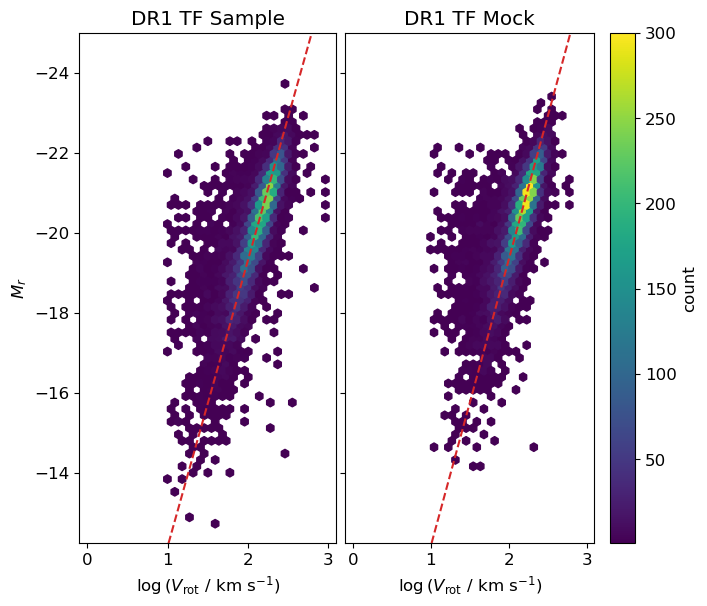

In [29]:
fig, axes = plt.subplots(1,2, figsize=(7,6), sharex=True, sharey=True,
                         gridspec_kw={'wspace':0.03, 'width_ratios':[0.825,1]})

ax = axes[0]
ax.hexbin(tfrcat['logv_rot'], tfrcat['R_ABSMAG_SB26'],
          cmap='viridis', mincnt=1, 
          vmin=1, vmax=3e2,
          gridsize=(35,40), extent=(-0.1, 3.1, -25, -12.25))
ax.set(xlim=(-0.1,3.1),
       xlabel=r'$\log{(V_\mathrm{rot}~/~\mathrm{km~s}^{-1})}$',
       ylabel=r'$M_{r}$',
       ylim=(-12.25, -25),
       title=f'DR1 TF Sample')# ({tfr_version})');

_log_v_rot = np.arange(-0.1, 3.05, 0.05)
b0 = -5
a0 = -7.16
ax.plot(_log_v_rot, b0 + a0*_log_v_rot, ls='--', color='tab:red')

ax = axes[1]
h = ax.hexbin(mock_downsample['LOGVROT_MOCK'], mock_downsample['R_ABSMAG_SB26_MOCK'],
              cmap='viridis', mincnt=1, 
              vmin=1, vmax=3e2,
              gridsize=(35,40), extent=(-0.1, 3.1, -25, -12.25))
cb = fig.colorbar(h, ax=ax, label='count')

ax.set(xlim=(-0.1,3.1),
       xlabel=r'$\log{(V_\mathrm{rot}~/~\mathrm{km~s}^{-1})}$',
       # ylabel=r'$M_{r,\mathrm{Y1}}$',
       ylim=(-12.25, -25),
       title=f'DR1 TF Mock')

_log_v_rot = np.arange(-0.1, 3.05, 0.05)
b0 = -5
a0 = -7.16
ax.plot(_log_v_rot, b0 + a0*_log_v_rot, ls='--', color='tab:red')

fig.subplots_adjust(left=0.1, right=0.925, top=0.95, bottom=0.1)
# fig.savefig('TF_mock_dr1_relation.png', dpi=200)

mpl.rc('font', size=11);

### Compute the luminosity distance and maximum volume for each galaxy

Since the SGA is size-limited, with $D_{26}>0.2'$, there is a maximum volume within which the galaxy could be located to be included in the SGA. Calculate the maximum volume to be used as a weight in the TFR calibration.

In [30]:
# Get some redshift-distance lookup tables
red_spline, lumred_spline, dist_spline, lumdist_spline, ez_spline = rz_table()  ##redshift distance lookup tables. Can use astropy instead

In [31]:
##compute comoving distances for galaxies in our sample
dz_sample_full = sp.interpolate.splev(mock["zobs"], dist_spline)
dz_sample = sp.interpolate.splev(mock_downsample["zobs"].to_numpy(), dist_spline)

##define min and max redshift cuts
zmin, zmax = np.min(mock['zobs']), np.max(mock['zobs'])

##cubic volume limits given luminosity distance 
Vmin, Vmax = (1.0+zmin)**3*sp.interpolate.splev(zmin, dist_spline)**3, (1.0+zmax)**3*sp.interpolate.splev(zmax, dist_spline)**3  

## logv limits (rotational velocities are between 10 and 1000 km/s
logvmin, logvmax = 1,3

In [32]:
##compute max luminosity distance at which each individual galaxy would be observable based on the diameter limited sample
theta_min=np.radians(20*u.arcsec).value
Dlim = ((mock_downsample["D26_kpc"]/1e3)/ np.tan(theta_min))*(1.0 + mock_downsample["zobs"].to_numpy())**2 ### since distance should be in Mpc
zlim = sp.interpolate.splev(Dlim, lumred_spline)  ##compute max redshift that each galaxy would be observable (based of luminosity)

In [33]:
##### remove any object where the observed reshift is inconsistent with this limit:
print(np.sum(zlim < mock_downsample["zobs"]))
# mock_downsample = mock_downsample[zlim > mock_downsample["zobs"]]

# ##### recompute for the galaxies that stay so we have the right sample size
# Dlim = ((mock_downsample["D26_kpc"]/1e3)/ np.tan(theta_min))*(1.0 + mock_downsample["zobs"].to_numpy())**2 ### since distance should be in Mpc
# zlim = sp.interpolate.splev(Dlim, lumred_spline)  ##compute max redshift that each galaxy would be observable (based of luminosity)

23


### Define the selection function weighting 

In [34]:
Sn = np.where(zlim >= zmax, 1.0, np.where(zlim <= zmin, 0.0, (Dlim**3 - Vmin)/(Vmax - Vmin))) ##compute selection effect weighting to account for incompleteness in sample caused by redshift and magnitude cuts (based off fraction of survey volume where galaxy with magnitude m_r could be observed) 
# Sn = np.ones(len(zlim)) ## if running with no weighting

## Fit 2D Gaussian to downsampled mock

In [35]:
##### Initialize the fitting sample and outlier list for the iterative fit
data_fit = mock_downsample
badcount = len(mock_downsample)
print(len(data_fit), badcount)

# Fit the TFR
ii = 0
converged = False  ##initialise convergence flag for fitting algorithm
start = time.time()
while not converged: ##FP fitting algorithm (see Howlett et. al., 2022 for details)

    ii += 1
    dz_sample_fit = sp.interpolate.splev(data_fit["zobs"].to_numpy(), dist_spline) ##compute cluster comoving distance for fitting subset(subset of dz_cluster_nosirals)
    Dlim = ((data_fit["D26_kpc"]/1e3)/ np.tan(theta_min))*(1.0 + data_fit["zobs"].to_numpy())**2  ##max observable luminsity distance of galaxy for fitting subset(subset of prev. Dlim)
    zlim = sp.interpolate.splev(Dlim, lumred_spline)  ##max observable redshift of galaxy for fitting subset(subset of prev. zlim)
    Snfit = np.where(zlim >= zmax, 1.0, np.where(zlim <= zmin, 0.0, (Dlim**3 - Vmin)/(Vmax - Vmin))) ##compute selection effect weighting (Sn) for fitting subset(subset of prev. Sn)
    # Snfit = np.ones(len(zlim)) ##affectively removes weighting parameter Sn

    avals = (-10, -4)        # slope
    bvals = (-25, -15)      # intercept
    v0vals = (1.6, 2.2)     # logV0
    sintvals = (0.01, 1.0)  # intrinsic scatter
    bounds = (avals, bvals, v0vals, sintvals)

    TFparams = sp.optimize.differential_evolution(TF_perp_func, bounds=bounds,
                                                  args=(0.0,  # placeholder for logdists
                                                        data_fit["zobs"].to_numpy(),  # redshifts
                                                        data_fit["LOGVROT_MOCK"].to_numpy(),        # observed log velocities
                                                        data_fit["R_ABSMAG_SB26_MOCK"].to_numpy(),  # observed magnitudes
                                                        data_fit["LOGVROT_ERR_MOCK"].to_numpy(),    # velocity errors
                                                        data_fit["R_ABSMAG_SB26_ERR_MOCK"].to_numpy(),  # magnitude errors
                                                        Snfit,
                                                        logvmin), #10 km/s
                                                  maxiter=10000, tol=1e-6, disp=False)

    #computes (x-xmean)C_n^{-1}(x-xmean)^T for all TF galaxies
    chi_squared = TF_perp_func(TFparams.x, 0.0,
                                  zobs=mock_downsample["zobs"].to_numpy(),
                                  logv=mock_downsample["LOGVROT_MOCK"].to_numpy(),
                                  m=mock_downsample["R_ABSMAG_SB26_MOCK"].to_numpy(),
                                  err_logv=mock_downsample["LOGVROT_ERR_MOCK"].to_numpy(),
                                  err_m=mock_downsample["R_ABSMAG_SB26_ERR_MOCK"].to_numpy(),
                                  Sn=Sn,
                                  logvmin=logvmin, #10 km/s
                                  sumgals=False,
                                  chi_squared_only=True)


    ##compute p-value of fit for all calibration galaxies (seven parameters: a, b, m , logv, sig_m, sig_v, cov)
    dof = 4
    pvals = stats.chi2.sf(chi_squared, np.sum(chi_squared)/(len(mock_downsample) - dof)) 

    ##reassign data_fit with galaxies that have pvalue>0.01 (not outliers)
    data_fit = mock_downsample.drop(mock_downsample[pvals < 0.01].index).reset_index(drop=True)
    badcountnew = len(np.where(pvals < 0.01)[0]) ##count of all removed outliers
    converged = True if badcount == badcountnew else False  ##update converged to end loop if the number of outliers hasn't changed
    print(TFparams.x, np.sum(chi_squared), len(data_fit), stats.chi2.isf(0.01, np.sum(chi_squared)/(len(mock_downsample) - dof)), np.sum(chi_squared)/(len(mock_downsample) - dof), badcount, badcountnew, converged)
    print(f'Reduced chi^2 value = {np.sum(chi_squared) / (len(mock_downsample) - dof):.4f}')
    badcount = badcountnew

print(time.time()-start)


10200 10200
[ -7.17255787 -19.26568228   2.00792546   0.07943727] 11874.108116115833 9951 7.114053100129228 1.164584946657104 10200 249 False
Reduced chi^2 value = 1.1646
[ -7.0770455  -16.74567436   1.65203581   0.06694906] 14834.164586101353 9909 7.89366747555535 1.4549004105630985 249 291 False
Reduced chi^2 value = 1.4549
[ -7.08306182 -16.82573854   1.66391307   0.06529015] 15310.911254177836 9894 8.013115393559088 1.5016586165337227 291 306 False
Reduced chi^2 value = 1.5017
[ -7.07929781 -19.91002545   2.09937458   0.06478518] 15461.502564678218 9890 8.050544418983632 1.516428262522383 306 310 False
Reduced chi^2 value = 1.5164
[ -7.0820942  -20.2920988    2.15332211   0.06465848] 15499.05902418354 9889 8.059857017001542 1.5201117128465613 310 311 False
Reduced chi^2 value = 1.5201
[ -7.08012772 -17.60084338   1.77317832   0.064623  ] 15509.908429587325 9889 8.062545645346011 1.521175797331044 311 311 True
Reduced chi^2 value = 1.5212
5.206844806671143


In [36]:
TFparams = TFparams.x
a = TFparams[0]
b = TFparams[1]

logV0 = TFparams[2]
sigma_int = TFparams[3]
print(a,b, sigma_int)

-7.080127723197779 -17.600843377308486 0.0646229965849136


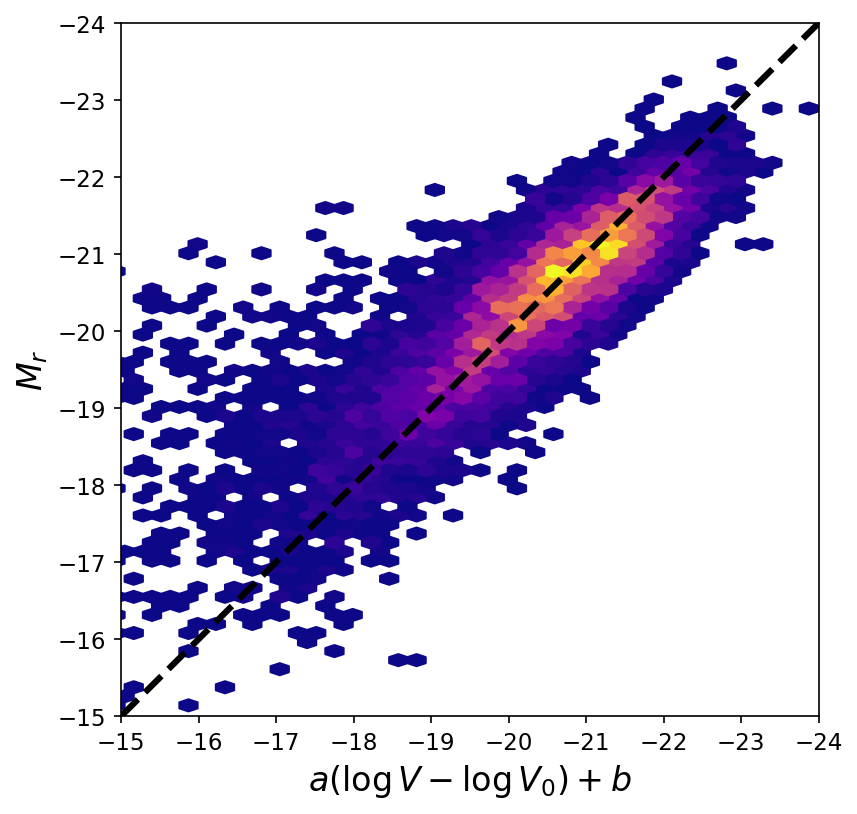

In [37]:
plt.figure(figsize=(6,6), facecolor='none', dpi=150)
plt.hexbin(x=a*(data_fit['LOGVROT_MOCK']-logV0) +b, y = data_fit['R_ABSMAG_SB26_MOCK'], cmap='plasma', mincnt=1, gridsize=(50,50), )
plt.xlabel(r'$a (\log V - \log V_0) + b$', fontsize=16)
plt.ylabel(r'$M_r$', fontsize=16)
plt.plot([-30,-10], [-30,-10], 'k--', lw=3, zorder=5)

plt.xlim(-15,-24)
plt.ylim(-15,-24)
plt.show()

/global/homes/s/sgmoore1/.local/lib/python3.10/site-packages/astroML/plotting/scatter_contour.py:96: UserWarning: linewidths is ignored by contourf
  contours = ax.contourf(H.T, levels, extent=extent, **contour_args)


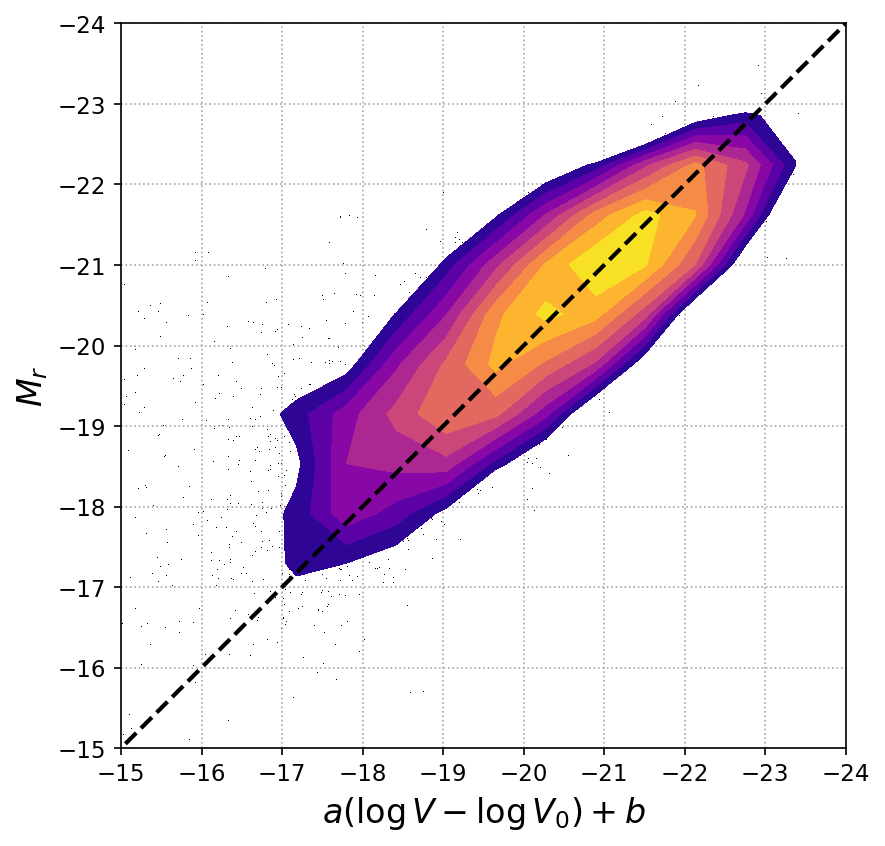

In [38]:
fig, ax = plt.subplots(figsize=(6,6), facecolor='none', dpi=150)
ax.set_xlim(-15, -24)
ax.set_ylim(-15, -24)

# Scatter + Gaussian-like density contours
scatter_contour(a*(data_fit['LOGVROT_MOCK']-logV0) + b, data_fit['R_ABSMAG_SB26_MOCK'],
                threshold=25, log_counts=True, ax=ax,
               histogram2d_args=dict(bins=20),
               plot_args=dict(marker=',', linestyle='none', color='black'),
               contour_args=dict(cmap=plt.cm.plasma, linewidths=2))

# y=x reference line
ax.plot([-25, -14], [-25, -14], 'k--', lw=2, label='y=x')

# Labels
ax.set_xlabel(r'$a (\log V - \log V_0) + b$', fontsize=16)
ax.set_ylabel(r'$M_r$', fontsize=16)
ax.set_aspect('equal')
ax.grid(True, linestyle=':', color='0.65')
plt.tight_layout()
plt.show()


### Apply outlier identification to full sample
Use the sample probabilistic cut during the fitting

In [39]:
#### Now compute the chi^2 values to determine outliers in the full sample

Dlim = ((mock["D26_kpc"]/1e3)/ np.tan(theta_min))*(1.0 + mock["zobs"].to_numpy())**2  ##max observable luminsity distance of galaxy for fitting subset
zlim = sp.interpolate.splev(Dlim, lumred_spline)  ##max observable redshift of galaxy for fitting subset
mock["Sn"] = np.where(zlim >= zmax, 1.0, np.where(zlim <= zmin, 0.0, (Dlim**3 - Vmin)/(Vmax - Vmin))) ##recompute and save Sn values to dataframe

chi_squared = TF_perp_func(TFparams, 0.0,
                              zobs=mock["zobs"].to_numpy(),
                              logv=mock["LOGVROT_MOCK"].to_numpy(),
                              m=mock["R_ABSMAG_SB26_MOCK"].to_numpy(),
                              err_logv=mock["LOGVROT_ERR_MOCK"].to_numpy(),
                              err_m=mock["R_ABSMAG_SB26_ERR_MOCK"].to_numpy(),
                              Sn=mock["Sn"],
                              logvmin=logvmin, #10 km/s
                              sumgals=False,
                              chi_squared_only=True)

pvals = stats.chi2.sf(chi_squared, np.sum(chi_squared)/(len(mock) - dof)) 

outlier_boolean = pvals < 0.01
np.sum(outlier_boolean)

6590

In [40]:
mock['MAIN'] = ~outlier_boolean
mock['OUTLIER'] = outlier_boolean
mock_main = mock['MAIN']

## Compute Eta values

The distance modulus is defined as 

$$
\mu_\mathrm{TF} =  m_{r,\mathrm{SB_{26}}} - M_{r,\mathrm{TF}}.
$$

and the logdistance ratios by 

$$
\eta = \log{\left(\frac{D_z}{D_\mathrm{TFR}}\right)}
$$

But in this case, we can fit for the $\eta$ values based on the following integral:

$$
[type integral]
$$

The bounds on our likelihood are given by
$$ v_{min} = \log(10), v_{max} = \log(1000)$$
based on our velocity cuts, and then based on the diameter-limited sample, we have the following magnitude limit:

$$ M_\mathrm{lim} = \mu_{\rm iso} - 5 \log_{10}(\theta_{\rm min}) - 5 \log_{10}(D_L / 10\ \mathrm{pc})$$

where $\mu = 26$ based on the isophote we use, $D_L$ = luminosity distance in pc

### Calculate the true $\eta$ value

In [41]:
mu_zcmb = cosmology.distmod(mock['zobs']).to_value('mag')
mu_zcos = cosmology.distmod(mock['zcos']).to_value('mag')

eta_true = 0.2 * (mu_zcmb - mu_zcos)

### Fit for measured $\eta$

In [42]:
# Fit the log-distance ratios
dmin, dmax, nd = -1.5, 1.5, 1001  # log-distance ratio limits
dbins = np.linspace(dmin, dmax, nd, endpoint=True)  # bins for log-distance shifts

# Compute 'true' distance for each galaxy for each log-distance shift
# Shape: (nd, N_galaxies)
d_H = 10.0**(-dbins)[:, None] * dz_sample_full[None, :]  # multiply each galaxy by each dbin

# Luminosity distance in parsecs for each shift
D_L = d_H * (1.0 + mock["zobs"].to_numpy())[None, :] * 1e6  # Mpc -> pc

# Minimum absolute magnitude as function of distance shift
mu_iso = 26.0  # mag/arcsec^2
theta_min = 20.0  # arcsec
# Shape: (nd, N_galaxies)
Mmin = mu_iso - 5.0 * np.log10(theta_min) - 5.0 * np.log10(D_L / 10.0)

# Velocity limits (can also be functions of dbins if needed)
logvmin = np.log10(10)
logvmax = np.log10(1000)

# Compute log-likelihood using the TF_FP_func
loglike = TF_FP_func(
    TFparams,
    dbins,
    mock["zobs"].to_numpy(),  # observed redshifts
    mock["LOGVROT_MOCK"].to_numpy(),        # observed log velocities
    mock["R_ABSMAG_SB26_MOCK"].to_numpy(),  # observed magnitudes
    mock["LOGVROT_ERR_MOCK"].to_numpy(),
    mock["R_ABSMAG_SB26_ERR_MOCK"].to_numpy(),
    Sn=mock['Sn'].to_numpy(),
    # Sn=np.ones(len(sgatab)),
    logvmin=logvmin,
    sumgals=False
)

/tmp/ipykernel_72848/2848880567.py:16: RuntimeWarning: invalid value encountered in log10
  Mmin = mu_iso - 5.0 * np.log10(theta_min) - 5.0 * np.log10(D_L / 10.0)


In [43]:
# Compute selection function accounting for diameter cut and distance shifts
start = time.time()
FNvals = TF_FN_func(
    TFparams,
    mock["LOGVROT_MOCK"].to_numpy(),    
    mock["R_ABSMAG_SB26_MOCK"].to_numpy(),
    mock["LOGVROT_ERR_MOCK"].to_numpy(),
    mock["R_ABSMAG_SB26_ERR_MOCK"].to_numpy(),
    logvmin=logvmin,
    logvmax=logvmax,
    Mmin=Mmin
)
print(time.time() - start)

81.2352557182312


In [44]:
# Convert to the PDF for logdistance
logP_dist = -1.5*np.log(2*np.pi) - loglike - FNvals[None, :] 

ddiff = np.log10(d_H[:-1, :]) - np.log10(d_H[1:, :])
valdiff = np.exp(logP_dist[1:, :]) + np.exp(logP_dist[:-1, :])  # (nd-1, Ngal)
norm = 0.5 * np.sum(valdiff * ddiff, axis=0)  # (Ngal,)
logP_dist -= np.log(norm)[None, :]  # (nd, Ngal)

/tmp/ipykernel_72848/1874263973.py:4: RuntimeWarning: invalid value encountered in log10
  ddiff = np.log10(d_H[:-1, :]) - np.log10(d_H[1:, :])


In [45]:
# Calculate the mean and variance of the gaussian, then the skew
mean = np.sum(dbins[0:-1,None]*np.exp(logP_dist[0:-1])+dbins[1:,None]*np.exp(logP_dist[1:]), axis=0)*(dbins[1]-dbins[0])/2.0 ##trapazoidal integral of logR* likelihood over dbins for each galaxy (mean of gaussian)
err = np.sqrt(np.sum(dbins[0:-1,None]**2*np.exp(logP_dist[0:-1])+dbins[1:,None]**2*np.exp(logP_dist[1:]), axis=0)*(dbins[1]-dbins[0])/2.0 - mean**2) 
gamma1 = (np.sum(dbins[0:-1,None]**3*np.exp(logP_dist[0:-1])+dbins[1:,None]**3*np.exp(logP_dist[1:]), axis=0)*(dbins[1]-dbins[0])/2.0 - 3.0*mean*err**2 - mean**3)/err**3
gamma1 = np.where(gamma1 > 0.99, 0.99, gamma1)
gamma1 = np.where(gamma1 < -0.99, -0.99, gamma1)
delta = np.sign(gamma1)*np.sqrt(np.pi/2.0*1.0/(1.0 + ((4.0 - np.pi)/(2.0*np.abs(gamma1)))**(2.0/3.0)))
scale = err*np.sqrt(1.0/(1.0 - 2.0*delta**2/np.pi))
loc = mean - scale*delta*np.sqrt(2.0/np.pi)
alpha = delta/(np.sqrt(1.0 - delta**2))


/tmp/ipykernel_72848/1272855196.py:7: RuntimeWarning: divide by zero encountered in true_divide
  delta = np.sign(gamma1)*np.sqrt(np.pi/2.0*1.0/(1.0 + ((4.0 - np.pi)/(2.0*np.abs(gamma1)))**(2.0/3.0)))


In [46]:
### Save the logdistance values:
eta_mock = mean
eta_err_mock = err

### Calculate the corresponding $\mu$ values:

In [47]:
mu_TF = mu_zcmb - 5*eta_mock
mu_TF_err = 5*eta_err_mock

## Diagnostic Plots

### $\eta$ dependence with $z$

In [49]:
idx_mock_good = ~outlier_boolean

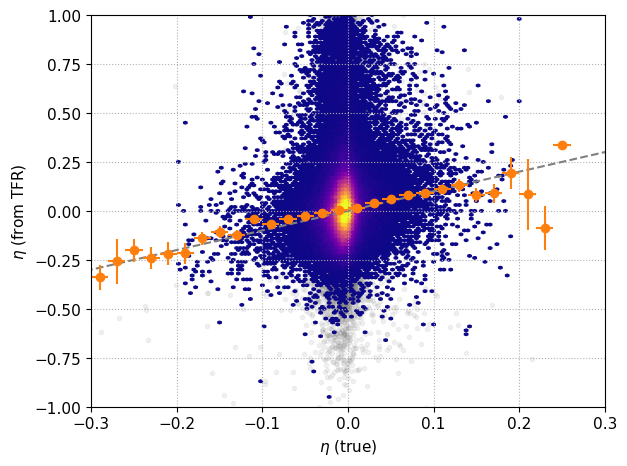

In [77]:
plt.figure(tight_layout=True)

plt.plot(eta_true[~idx_mock_good], eta_mock[~idx_mock_good], '.', c='gray', alpha=0.1, zorder=0)
# plt.plot(eta_true[mock_main], eta_mock[mock_main], '.', alpha=0.1, zorder=1)
plt.hexbin(eta_true[idx_mock_good], 
           eta_mock[idx_mock_good], 
           cmap='plasma', 
           mincnt=1, 
           vmin=1, 
           vmax=1000, 
           gridsize=(100,100), 
           extent=(-0.2, 0.2, -1, 1))

plt.plot([-5, 2], [-5, 2], '--', c='gray')

eta_bins = np.arange(-0.5, 0.3, 0.02)
d_eta = 0.5*np.diff(eta_bins)
eta_c = 0.5*(eta_bins[1:] + eta_bins[:-1])

_, eta_avg, eta_std = profile_histogram(eta_true[idx_mock_good], eta_mock[idx_mock_good], eta_bins, stat='median')
plt.errorbar(eta_c, eta_avg, xerr=d_eta, yerr=eta_std, fmt='o', color='tab:orange', zorder=2)

plt.grid(ls=':')

# plt.xlim([-0.2, 0.2])
plt.xlim([-0.3,0.3])
plt.ylim([-1, 1])

plt.xlabel(r'$\eta$ (true)')
plt.ylabel(r'$\eta$ (from TFR)');

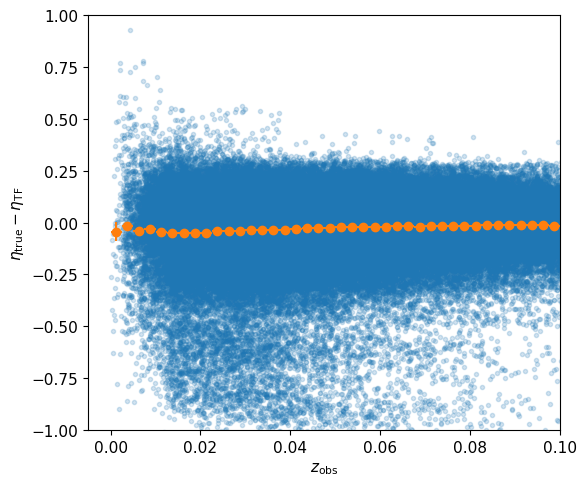

In [55]:
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)

ax.scatter(mock['zobs'][idx_mock_good], eta_true[idx_mock_good] - eta_mock[idx_mock_good], alpha=0.2, marker='.')

_, deta_avg, deta_std = profile_histogram(mock['zobs'][idx_mock_good], eta_true[idx_mock_good] - eta_mock[idx_mock_good], zbins)
ax.errorbar(zc, deta_avg, xerr=dz, yerr=deta_std, fmt='o', color='tab:orange')

ax.set(xlabel=r'$z_\mathrm{obs}$',
       xlim=(-0.005,0.1),
       ylim=(-1,1),
       ylabel=r'$\eta_\mathrm{true} - \eta_\mathrm{TF}$');

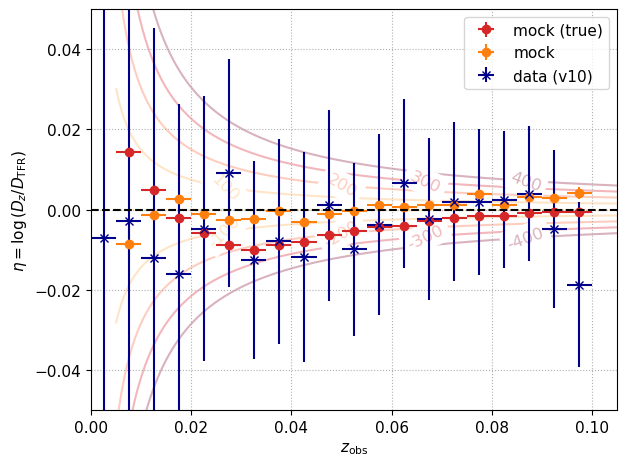

In [56]:
fig = plt.figure(tight_layout=True)

_zbins = np.arange(0, 0.105, 0.005)
dz = 0.5*np.diff(_zbins)
zc = 0.5*(_zbins[1:] + _zbins[:-1])


plt.grid(ls=':')

# True mock
_, eta_avg, eta_std = profile_histogram(mock['zobs'][mock_main], 
                                        eta_true[mock_main], 
                                        _zbins)
plt.errorbar(zc, eta_avg, xerr=dz, yerr=eta_std, fmt='o', color='tab:red', label='mock (true)')

# Mock
_, eta_avg, eta_std = profile_histogram(mock['zobs'][mock_main], 
                                        eta_mock[mock_main], 
                                        _zbins, 
                                        weights=eta_err_mock[mock_main]**-2, 
                                        weighted=True)
plt.errorbar(zc, eta_avg, xerr=dz, yerr=eta_std, fmt='o', color='tab:orange', label='mock')

# Data
_, data_eta_avg, data_eta_std = profile_histogram(tfrcat['Z_DESI'][tfrcat['MAIN']], 
                                                  tfrcat['LOGDIST'][tfrcat['MAIN']], 
                                                  _zbins, 
                                                  weights=tfrcat['LOGDIST_ERR'][tfrcat['MAIN']]**-2, 
                                                  weighted=True)
plt.errorbar(zc, data_eta_avg, xerr=dz, yerr=data_eta_std, fmt='x', color='darkblue', label=f'data ({tfr_version})')

#-------------------------------------------------------------------------------
# PV lines (code taken from Cullen)
#-------------------------------------------------------------------------------
LightSpeed = const.c.to('km/s').value
velarray = np.arange(-400, 401, 100)
zarray = np.linspace(0.005, 0.11, 200)

dzarray = cosmology.comoving_distance(zarray).value
dharray = cosmology.comoving_distance(np.outer(1.0/(1.0 + velarray/LightSpeed), 
    								  (1.0 + zarray)) - 1.0).value
deltamarray = np.log10(dzarray/dharray)

rotation = [20.0, 25.0, 30.0, 45.0, 0.0, -45.0, -30.0, -25.0, -20.0]
labels = ["-400", "-300", "-200", "-100", "0", "100", "200", "300", "400"]
xcoord = np.array([26000.0, 20000.0, 15000.0, 8000.0, -1000.0, 8000.0, 15000.0, 20000.0, 26000.0])
coord = np.searchsorted(zarray, xcoord/LightSpeed)
ycoord = np.array([deltamarray[i,j] for i, j in enumerate(coord)])

colors = 0.8*np.fabs(velarray)/np.amax(np.fabs(velarray)) + 0.2

for v in range(len(velarray)):
    c = plt.cm.YlOrRd(colors[v])

    plt.plot(zarray, deltamarray[v,:], 
             color=c, 
             linestyle='-', 
             alpha=0.3, 
             zorder=0)

    if (v != 4):
        plt.text(xcoord[v]/LightSpeed, ycoord[v], 
                 labels[v], 
                 color=c, 
                 fontsize=12, 
                 rotation=rotation[v], 
                 ha="center", 
                 va="center", 
                 bbox=dict(boxstyle="square", ec="w", fc="w"), 
                 zorder=1, 
                 alpha=0.3)

# Line at eta = 0
plt.hlines(0, 0, 0.2, linestyles='dashed', colors='k', zorder=5)
#-------------------------------------------------------------------------------

plt.legend()

plt.xlabel(r'$z_\mathrm{obs}$')
plt.ylabel(r'$\eta = \log{(D_z / D_\mathrm{TFR})}$')

plt.xlim(0,0.105)
plt.ylim(-0.05, 0.05);

# fig.savefig('tfr_mock_eta.png', dpi=150);

(0.0, 0.105)

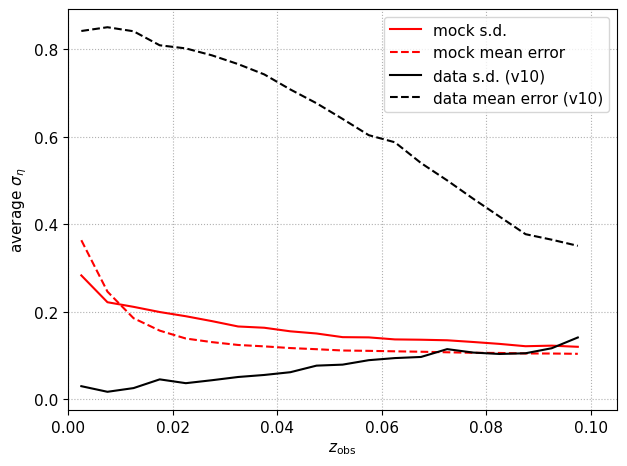

In [57]:
# In each redshift bin, compute the standard deviation of the log-distance ratios
# And compare this to the average value of the uncertainty in the log-distance ratio in each bin
# Do this for both mocks and data

plt.figure(tight_layout=True)

plt.grid(ls=':')

_zbins = np.arange(0, 0.105, 0.005)
dz = 0.5*np.diff(_zbins)
zc = 0.5*(_zbins[1:] + _zbins[:-1])

# Mock standard deviation in each bin
_, eta_std,_ = profile_histogram(mock['zobs'][mock_main], 
                                 eta_mock[mock_main], 
                                 _zbins, 
                                 stat='std')
plt.plot(zc, eta_std, 'r', label='mock s.d.')

# Mock average error
_, eta_err_avg,_ = profile_histogram(mock['zobs'][mock_main], 
                                     eta_err_mock[mock_main], 
                                     _zbins)
plt.plot(zc, eta_err_avg, 'r--', label='mock mean error')

# Data standard deviation in each bin
_, data_eta_std,_ = profile_histogram(tfrcat['Z_DESI'][tfrcat['MAIN']], 
                                      tfrcat['LOGDIST'][tfrcat['MAIN']], 
                                      _zbins, 
                                      stat='std')
plt.plot(zc, data_eta_std, 'k', label=f'data s.d. ({tfr_version})')

# Data average error
_, data_eta_err_avg,_ = profile_histogram(tfrcat['Z_DESI'][tfrcat['MAIN']], 
                                          tfrcat['LOGDIST_ERR'][tfrcat['MAIN']], 
                                          _zbins)
plt.plot(zc, data_eta_err_avg, 'k--', label=f'data mean error ({tfr_version})')


plt.legend()

plt.xlabel(r'$z_\mathrm{obs}$')
plt.ylabel(r'average $\sigma_\eta$')

plt.xlim(0,0.105)
# plt.ylim(0.08, 0.18);

/tmp/ipykernel_72848/497888321.py:1: RuntimeWarning: invalid value encountered in log10
  logdist_true = np.log10(cosmology.comoving_distance(mock['zobs'].to_numpy()).value/cosmology.comoving_distance(mock['zcos'].to_numpy()).value)


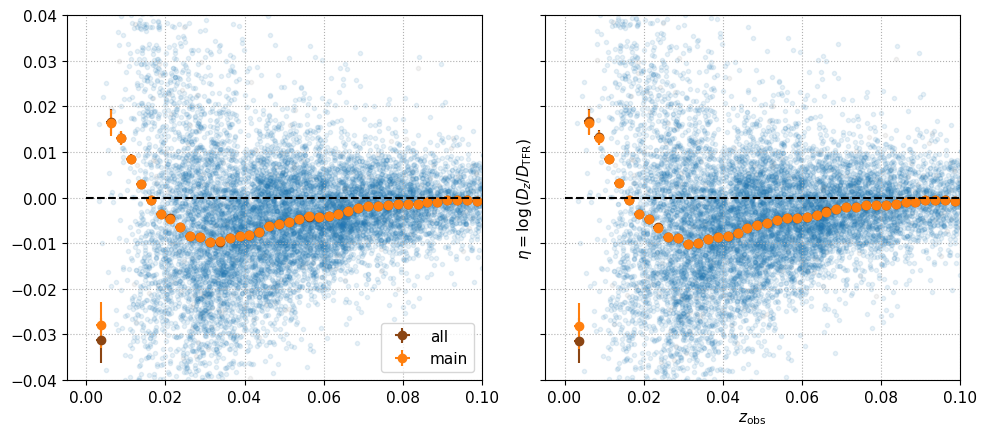

In [59]:
logdist_true = np.log10(cosmology.comoving_distance(mock['zobs'].to_numpy()).value/cosmology.comoving_distance(mock['zcos'].to_numpy()).value)

fig, axes = plt.subplots(1,2, figsize=(10,4.5), tight_layout=True, sharex=True, sharey=True)

ax = axes[0]
ax.scatter(mock['zobs'][~mock_main][::20], logdist_true[~mock_main][::20], 
           marker='.', 
           c='gray',
           alpha=0.1)
ax.scatter(mock['zobs'][mock_main][::20], logdist_true[mock_main][::20], 
           marker='.', alpha=0.1)

ax = axes[1]
ax.scatter(mock['zobs'][~mock_main][::20], eta_true[~mock_main][::20], 
           marker='.', 
           c='gray',
           alpha=0.1)
ax.scatter(mock['zobs'][mock_main][::20], eta_true[mock_main][::20], 
           marker='.', alpha=0.1)

zbins = np.arange(0, 0.1025, 0.0025)
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

ax = axes[0]
_, eta_avg, eta_std = profile_histogram(mock['zobs'], logdist_true, zbins)
ax.errorbar(zc, eta_avg, xerr=dz, yerr=eta_std, fmt='o', color='saddlebrown', label='all')
_, eta_avg, eta_std = profile_histogram(mock['zobs'][mock_main], logdist_true[mock_main], zbins)
ax.errorbar(zc, eta_avg, xerr=dz, yerr=eta_std, fmt='o', color='tab:orange', label='main')

ax.hlines(0, zbins[0], zbins[-1], colors='k', linestyles='dashed', zorder=10)
ax.grid(ls=':')

ax.legend()

ax = axes[1]
_, eta_avg, eta_std = profile_histogram(mock['zobs'], eta_true, zbins)
ax.errorbar(zc, eta_avg, xerr=dz, yerr=eta_std, fmt='o', color='saddlebrown', label='all')
_, eta_avg, eta_std = profile_histogram(mock['zobs'][mock_main], eta_true[mock_main], zbins)
ax.errorbar(zc, eta_avg, xerr=dz, yerr=eta_std, fmt='o', color='tab:orange', label='main')

ax.hlines(0, zbins[0], zbins[-1], colors='k', linestyles='dashed', zorder=10)

ax.set(xlabel=r'$z_\mathrm{obs}$',
       xlim=(-0.005,0.1),
       # ylim=(-1,1),
       ylim=(-0.04, 0.04),
       ylabel=r'$\eta = \log{(D_z / D_\mathrm{TFR})}$')
ax.grid(ls=':');

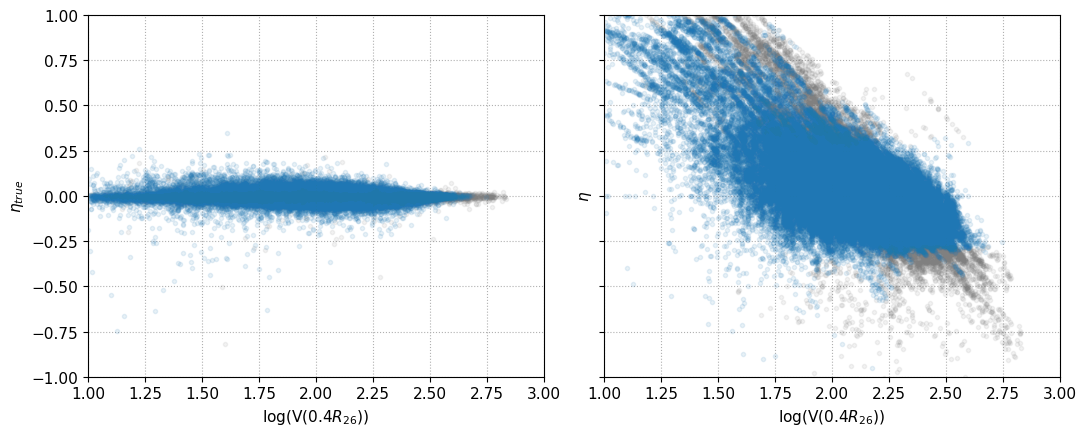

In [61]:
fig, axes = plt.subplots(1,2, figsize=(11,4.5), tight_layout=True, sharex=True, sharey=True)

# Truth
ax = axes[0]
ax.plot(logvrot_mock[~mock_main], eta_true[~mock_main], '.', alpha=0.1, c='gray')
ax.plot(logvrot_mock[mock_main], eta_true[mock_main], '.', alpha=0.1)

ax.grid(ls=':')

ax.set(xlabel='log(V(0.4$R_{26}$))', 
       ylabel='$\eta_{true}$', 
       ylim=(-1, 1), 
       xlim=(1,3))


# Mock (generated)
ax = axes[1]
ax.plot(logvrot_mock[~mock_main], eta_mock[~mock_main], '.', alpha=0.1, c='gray')
ax.plot(logvrot_mock[mock_main], eta_mock[mock_main], '.', alpha=0.1)

ax.grid(ls=':')

ax.set(xlabel='log(V(0.4$R_{26}$))', 
       ylabel='$\eta$');

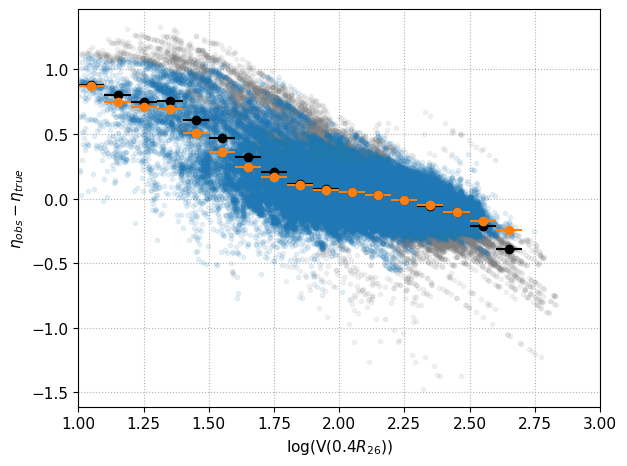

In [62]:
logv_bins = np.arange(1, 2.75, 0.1)
dv = 0.5*np.diff(logv_bins)
vc = 0.5*(logv_bins[1:] + logv_bins[:-1])

plt.figure(tight_layout=True)

plt.plot(logvrot_mock[~mock_main], 
         eta_mock[~mock_main] - eta_true[~mock_main], 
         '.', c='gray', alpha=0.1)

plt.plot(logvrot_mock[mock_main], 
         eta_mock[mock_main] - eta_true[mock_main], 
         '.', c='tab:blue', alpha=0.1)

_, dn_avg, dn_std = profile_histogram(logvrot_mock, eta_mock - eta_true, logv_bins, stat='median')
plt.errorbar(vc, dn_avg, xerr=dv, yerr=dn_std, fmt='o', color='black')

_, dn_avg, dn_std = profile_histogram(logvrot_mock[mock_main], 
                                      eta_mock[mock_main] - eta_true[mock_main], 
                                      logv_bins, 
                                      stat='median')
plt.errorbar(vc, dn_avg, xerr=dv, yerr=dn_std, fmt='o', color='tab:orange')

plt.grid(ls=':')

plt.xlim((1,3))

plt.xlabel('log(V(0.4$R_{26}$))')
plt.ylabel('$\eta_{obs} - \eta_{true}$');

### Correlation with magnitude

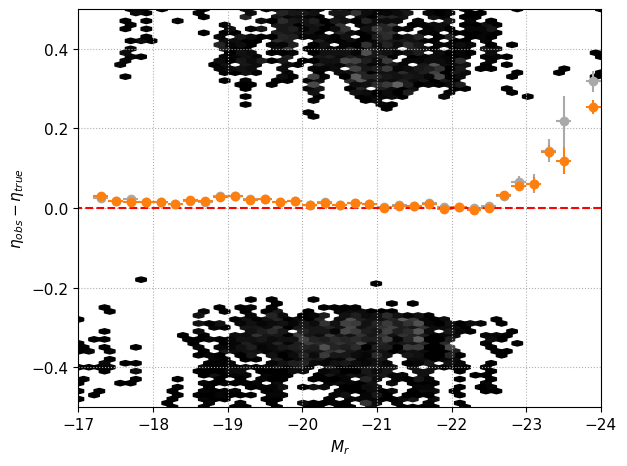

In [63]:
Mr_bins = np.arange(-24, -17, 0.2)
dMr = 0.5*np.diff(Mr_bins)
Mrc = 0.5*(Mr_bins[1:] + Mr_bins[:-1])

plt.figure(tight_layout=True)

plt.hexbin(mock['R_ABSMAG_SB26_MOCK'][~mock_main], 
           eta_mock[~mock_main] - eta_true[~mock_main], 
           cmap='Greys_r', 
           vmin=1, 
           vmax=50, 
           mincnt=1, 
           gridsize=(50, 50), 
           extent=(-24, -17, -0.5, 0.5))

# plt.hexbin(mock['R_ABSMAG_SB26_MOCK'][mock_main], 
#            eta_mock[mock_main] - eta_true[mock_main], 
#            cmap='viridis', 
#            vmin=1, 
#            vmax=400, 
#            mincnt=1, 
#            gridsize=(50, 50), 
#            extent=(-24, -17, -0.5, 0.5))

_, dn_avg, dn_std = profile_histogram(mock['R_ABSMAG_SB26_MOCK'], 
                                      eta_mock - eta_true, 
                                      Mr_bins, stat='median')
plt.errorbar(Mrc, dn_avg, xerr=dMr, yerr=dn_std, fmt='o', color='darkgrey')

_, dn_avg, dn_std = profile_histogram(mock['R_ABSMAG_SB26_MOCK'][mock_main], 
                                      eta_mock[mock_main] - eta_true[mock_main], 
                                      Mr_bins, 
                                      stat='median')
plt.errorbar(Mrc, dn_avg, xerr=dMr, yerr=dn_std, fmt='o', color='tab:orange')

plt.hlines(0, -24, -17, linestyles='dashed', colors='r')

plt.grid(ls=':')

plt.xlim((-17,-24))
plt.ylim(-0.5, 0.5)

plt.xlabel('$M_r$')
plt.ylabel('$\eta_{obs} - \eta_{true}$');

### Correlation with redshift

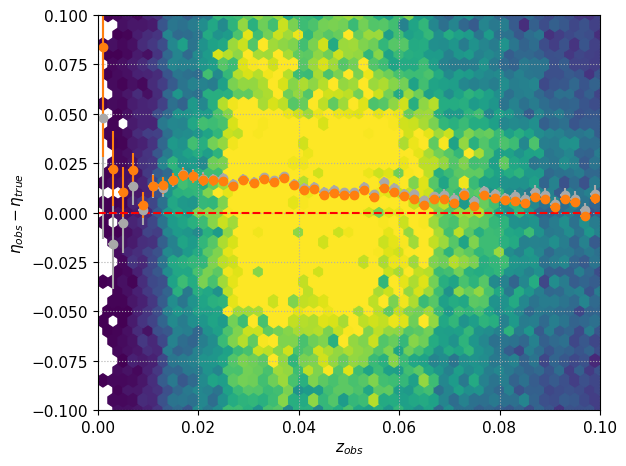

In [64]:
_zbins = np.arange(0, 0.2, 0.002)
dz = 0.5*np.diff(_zbins)
zc = 0.5*(_zbins[1:] + _zbins[:-1])

plt.figure(tight_layout=True)

plt.hexbin(mock['zobs'][~mock_main], 
           eta_mock[~mock_main] - eta_true[~mock_main], 
           cmap='Greys_r', 
           vmin=1, 
           vmax=50, 
           mincnt=1, 
           gridsize=(50, 100), 
           extent=(0, 0.1, -0.5, 0.5))

plt.hexbin(mock['zobs'][mock_main], 
           eta_mock[mock_main] - eta_true[mock_main], 
           cmap='viridis', 
           vmin=1, 
           vmax=100, 
           mincnt=1, 
           gridsize=(50, 100), 
           extent=(0, 0.1, -0.5, 0.5))

_, dn_avg, dn_std = profile_histogram(mock['zobs'], 
                                      eta_mock - eta_true, 
                                      _zbins, stat='median')
plt.errorbar(zc, dn_avg, xerr=dz, yerr=dn_std, fmt='o', color='darkgrey')

_, dn_avg, dn_std = profile_histogram(mock['zobs'][mock_main], 
                                      eta_mock[mock_main] - eta_true[mock_main], 
                                      _zbins, 
                                      stat='median')
plt.errorbar(zc, dn_avg, xerr=dz, yerr=dn_std, fmt='o', color='tab:orange')

plt.hlines(0, 0, 0.1, linestyles='dashed', colors='r')

plt.grid(ls=':')

plt.xlim(0, 0.1)
plt.ylim(-0.1, 0.1)

plt.xlabel('$z_{obs}$')
plt.ylabel('$\eta_{obs} - \eta_{true}$');

In [65]:
# fig, ax = plt.subplots(1,1, figsize=(6,4), tight_layout=True)
# ax.hist((eta_mock - eta_true) / eta_err_mock, bins=np.arange(-10,10.2,0.2))
# ax.set(xlabel=r'$(\eta_\mathrm{mock} - \eta_\mathrm{true})/\sigma_\eta$',
#        yscale='log')

## Write Output to FITS

In [66]:
# outfile = os.path.join('/global/cfs/cdirs/desi/science/td/pv/mocks/TF_mocks/fullmocks/v0.5.4',
#                        os.path.basename(mockfile).replace('.dat.hdf5', '.fits').replace('BGS_PV', 'TF'))
# outfile = os.path.join('/pscratch/sd/s/sgmoore1/TF/mocks/',
#                        os.path.basename(mockfile).replace('.dat.hdf5', '.fits').replace('BGS_PV', 'TF'))
outfile = f'/pscratch/sd/s/sgmoore1/TF/mocks/sys_tests/TF_Y1_mock_test_v10_{int(mock_num/60)}.fits'

# hdr = fits.Header(dict(NTF=len(mock),
#                        a=a_mcmc,
#                        b=b_mcmc,
#                        sigma=sigma_mcmc,
#                        cov_aa=cov_mcmc[0][0],
#                        cov_ab=cov_mcmc[0][1],
#                        cov_as=cov_mcmc[0][2],
#                        cov_bb=cov_mcmc[1][1],
#                        cov_bs=cov_mcmc[1][2],
#                        cov_ss=cov_mcmc[2][2]))

hdr = fits.Header({ 'NTF' : len(mock) } | \
                  {'mock': str(mockfile)} | \
                  { 'a' : a} | \
                  { 'b' : b} | \
                  { 'sigma' : sigma_int} ) 

col01 = fits.Column(name='RA',            format='D', array=mock['ra'].to_numpy())
col02 = fits.Column(name='DEC',           format='D', array=mock['dec'].to_numpy())
col03 = fits.Column(name='ZOBS',          format='D', array=mock['zobs'].to_numpy())
col04 = fits.Column(name='ZCOS',          format='D', array=mock['zcos'].to_numpy())
col05 = fits.Column(name='vx',            format='D', array=mock['vx'].to_numpy())
col06 = fits.Column(name='vy',            format='D', array=mock['vy'].to_numpy())
col07 = fits.Column(name='vz',            format='D', array=mock['vz'].to_numpy())
col08 = fits.Column(name='DWARF',         format='L', array=mock['OUTLIER'].to_numpy())
col09 = fits.Column(name='MAIN',          format='L', array=mock['MAIN'].to_numpy())
col10 = fits.Column(name='LOGVROT',       format='D', array=mock['LOGVROT_MOCK'].to_numpy())
col11 = fits.Column(name='R_ABSMAG_SB26', format='D', array=mock['R_ABSMAG_SB26_MOCK'].to_numpy())
col12 = fits.Column(name='LOGDIST_TRUE',  format='D', array=eta_true)
col13 = fits.Column(name='LOGDIST',       format='D', array=eta_mock)
col14 = fits.Column(name='LOGDIST_ERR',   format='D', array=eta_err_mock)
col15 = fits.Column(name='Y1_COMP',       format='D', array=mock['Y1_COMP'].to_numpy())
col16 = fits.Column(name='Y3_COMP',       format='D', array=mock['Y3_COMP'].to_numpy())

hdulist = fits.BinTableHDU.from_columns([col01, col02, col03, col04, col05,
                                         col06, col07, col08, col09, col10,
                                         col11, col12, col13, col14, col15,
                                         col16],
                                        header=hdr)
hdulist.writeto(outfile, overwrite=True)

# shutil.chown(outfile, group='desi')

In [67]:
# !jupyter nbconvert --to script TFR_mock_gen_v13.ipynb

In [68]:
# fit = Table.read('/pscratch/sd/s/sgmoore1/TF/mocks/TF_AbacusSummit_base_c000_ph000_r001_z0.11.fits')
# hdbscan = Table.read('/pscratch/sd/s/sgmoore1/TF/mocks/hdbscan/TF_AbacusSummit_base_c000_ph000_r001_z0.11.fits')

In [69]:
# fit[:5]

In [70]:
# fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)

# # ax.scatter(fit['ZCOS'],fit['LOGDIST'] - fit['LOGDIST_TRUE'], alpha=0.2, marker='.')
# # ax.scatter(hdbscan['ZCOS'],hdbscan['LOGDIST'] - hdbscan['LOGDIST_TRUE'], alpha=0.2, marker='.')
# z_bins = np.arange(0, 0.11, 0.01)
# z_c = 0.5*(z_bins[1:] + z_bins[:-1])
# dz = 0.5*np.diff(z_bins)

# sample1 = fit['MAIN']
# sample2 = hdbscan['MAIN']
# _, z_avg, z_std = profile_histogram(fit['ZOBS'][sample1], fit['LOGDIST'][sample1] - fit['LOGDIST_TRUE'][sample1], z_bins)
# ax.errorbar(z_c, z_avg, xerr=dz, yerr=z_std, fmt='o', color='tab:blue', label='Fit ellipse')

# _, z_avg, z_std = profile_histogram(hdbscan['ZOBS'][sample2], hdbscan['LOGDIST'][sample2] - hdbscan['LOGDIST_TRUE'][sample2], z_bins)
# ax.errorbar(z_c, z_avg, xerr=dz, yerr=z_std, fmt='o', color='tab:orange', label='Enclosing ellipse')

# ax.set(#xlim=(-0.5,0.5),
#        xlabel=r'$z_\mathrm{obs}$',
#        # ylim=(-1,2),
#        ylabel=r'$\eta_\mathrm{mock} - \eta_\mathrm{true}$');
# ax.legend()

In [71]:
# fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)

# # ax.scatter(fit['ZCOS'],fit['LOGDIST'] - fit['LOGDIST_TRUE'], alpha=0.2, marker='.')
# # ax.scatter(hdbscan['ZCOS'],hdbscan['LOGDIST'] - hdbscan['LOGDIST_TRUE'], alpha=0.2, marker='.')
# z_bins = np.arange(0, 0.11, 0.01)
# z_c = 0.5*(z_bins[1:] + z_bins[:-1])
# dz = 0.5*np.diff(z_bins)

# _, z_avg, z_std = profile_histogram(fit['ZOBS'], fit['LOGDIST'] - fit['LOGDIST_TRUE'], z_bins)
# ax.errorbar(z_c, z_avg, xerr=dz, yerr=z_std, fmt='o', color='tab:blue', label='Fit ellipse')

# _, z_avg, z_std = profile_histogram(hdbscan['ZOBS'], hdbscan['LOGDIST'] - hdbscan['LOGDIST_TRUE'], z_bins)
# ax.errorbar(z_c, z_avg, xerr=dz, yerr=z_std, fmt='o', color='tab:orange', label='Enclosing ellipse')

# ax.set(#xlim=(-0.5,0.5),
#        xlabel=r'$z_\mathrm{obs}$',
#        # ylim=(-1,2),
#        ylabel=r'$\eta_\mathrm{mock} - \eta_\mathrm{true}$');
# ax.legend()
# plt.title('Full samples')

In [72]:
# fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)

# ax.scatter(fit['ZCOS'][sample1],fit['LOGDIST'][sample1] - fit['LOGDIST_TRUE'][sample1], alpha=0.1, marker='.', label='Fit ellipse')
# ax.scatter(hdbscan['ZCOS'][sample2],hdbscan['LOGDIST'][sample2] - hdbscan['LOGDIST_TRUE'][sample2], alpha=0.1, marker='.', label='Enclosing ellipse')


# ax.set(#xlim=(-0.5,0.5),
#        xlabel=r'$z_\mathrm{obs}$',
#        # ylim=(-1,2),
#        ylabel=r'$\eta_\mathrm{mock} - \eta_\mathrm{true}$');
# ax.legend()

In [73]:


# plt.hist(fit['LOGDIST'][sample1] - fit['LOGDIST_TRUE'][sample1], alpha=0.5, label='Fit ellipse', bins=np.arange(-1,1,0.03), density=True)
# plt.hist(hdbscan['LOGDIST'][sample2] - hdbscan['LOGDIST_TRUE'][sample2], alpha=0.5, label='Enclosing ellipse', bins=np.arange(-1,1,0.03), density=True)

# plt.legend()

# plt.xlabel(r'$\eta_\mathrm{mock} - \eta_\mathrm{true}$');
# plt.ylabel('Density')